In [1]:
import pandas as pd 
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pymer4.models import Lmer
from nltools.stats import circle_shift, zscore
from tqdm import tqdm

%matplotlib inline
sns.set_style("white")

base_dir = os.path.dirname(os.getcwd())

/Users/emma/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/Users/emma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_csv(os.path.join(base_dir,'Analyses','binned_connection_and_gaps_strangers.csv'))

In [3]:
data.head()

,subID,partnerID,dyad,bin_num,gap_length_mean_1,gap_length_median_1,connection_1,num_turns_1,gap_length_mean_2,gap_length_median_2,...,connection_40,num_turns_40,gap_length_mean_60,gap_length_median_60,connection_60,num_turns_60,gap_length_mean_120,gap_length_median_120,connection_120,num_turns_120
0,100,101,100_101,0.0,350.018634,300.0,59.804833,161.0,345.333333,304.0,...,1.420000,8.0,425.000000,402.0,0.00,6.0,439.0,563.0,0.00,3.0
1,101,100,100_101,0.0,350.018634,300.0,65.760833,161.0,345.333333,304.0,...,31.293333,8.0,425.000000,402.0,14.69,6.0,439.0,563.0,0.56,3.0
2,100,101,100_101,1.0,NaN,NaN,NaN,NaN,356.426471,269.5,...,7.866667,5.0,453.750000,428.0,5.63,4.0,411.0,241.0,0.00,3.0
3,101,100,100_101,1.0,NaN,NaN,NaN,NaN,356.426471,269.5,...,74.380000,5.0,453.750000,428.0,68.25,4.0,411.0,241.0,28.82,3.0
4,100,101,100_101,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,21.993333,8.0,448.666667,460.0,8.30,3.0,315.0,315.0,4.26,2.0


# Effect of gap length on connection for each bin size

In [4]:
df_real = pd.DataFrame()
df_real = df_real.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.dropna().reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_zscore + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
    model.fit()
        
    df_real.at[counter, 'num_bins'] = num_bins
    df_real.at[counter, 'bin_size'] = 600 / num_bins
    df_real.at[counter, 'beta'] = model.coefs['Estimate'][1]
    df_real.at[counter, 'p-val'] = model.coefs['P-val'][1]

    counter += 1
        
df_real.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_different_bins_strangers.csv'), encoding='utf-8', index=False)
    

Formula: connection_2_zscore~gap_length_mean_2_zscore+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1413.796 	 AIC: 2827.592

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.246  0.496
subID     (Intercept)  0.327  0.572
Residual               0.322  0.568

No random effect correlations specified

Fixed effects:

Formula: connection_3_zscore~gap_length_mean_3_zscore+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2044.330 	 AIC: 4088.660

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.265  0.515
subID     (Intercept)  0.314  0.560
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:

Formula: connection_4_zscore~gap_length_mean_4_zscore+bin_num_zscore+(1|subI

# Circle-shift each bin

In [6]:
df_shifted = pd.DataFrame()
df_shifted = df_shifted.fillna(0)
counter = 0

num_bins_list = [2, 3, 4, 5, 6, 10, 12,
                15, 20, 24, 30, 40, 60, 120]

for num_bins in num_bins_list:
    
    columns = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num', 'subID', 'dyad']
    data_subset = data[columns]
    data_subset_no_nans = data_subset.dropna().reset_index(drop=True)

    variables = [f'connection_{num_bins}', f'gap_length_mean_{num_bins}', 'bin_num']
    for variable in variables:
        data_subset_no_nans[f'{variable}_zscore'] = zscore(data_subset_no_nans[variable])

    shifted_betas = []
    shifted_p_vals = []

    for _ in tqdm(range(100)): # change to 100 on cluster

        data_subset_no_nans[f'gap_length_mean_{num_bins}_shifted'] = data_subset_no_nans[f'gap_length_mean_{num_bins}_zscore'].groupby(data_subset_no_nans['dyad']).transform(circle_shift)
        model = Lmer(f"connection_{num_bins}_zscore ~ gap_length_mean_{num_bins}_shifted + bin_num_zscore + (1|subID) + (1|dyad)", data=data_subset_no_nans)
        model.fit()

        shifted_betas.append(model.coefs['Estimate'][1])
        shifted_p_vals.append(model.coefs['P-val'][1])
        
    for i in range(len(shifted_betas)):
        df_shifted.at[counter, 'num_bins'] = num_bins
        df_shifted.at[counter, 'bin_size'] = 600 / num_bins
        df_shifted.at[counter, 'betas'] = shifted_betas[i]
        df_shifted.at[counter, 'p-val'] = shifted_p_vals[i]
        
        counter += 1
        
df_shifted.to_csv(os.path.join(base_dir, 'Analyses', 'within_convo_analysis_circle_shifted_strangers.csv'), encoding='utf-8', index=False)
    


  1%|          | 1/100 [00:01<02:08,  1.30s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.376 	 AIC: 2836.753

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:02<02:07,  1.30s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.880 	 AIC: 2847.761

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:03<02:02,  1.27s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.308 	 AIC: 2846.616

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:04<01:53,  1.18s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.871 	 AIC: 2843.742

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:05<01:47,  1.13s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.265 	 AIC: 2848.529

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:06<01:43,  1.10s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1414.698 	 AIC: 2829.396

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.246  0.496
subID     (Intercept)  0.327  0.572
Residual               0.323  0.568

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:07<01:41,  1.09s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.295 	 AIC: 2836.590

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:08<01:38,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.995 	 AIC: 2847.990

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:09<01:37,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1416.518 	 AIC: 2833.037

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.246  0.496
subID     (Intercept)  0.327  0.572
Residual               0.324  0.569

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:11<01:35,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.875 	 AIC: 2847.749

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:12<01:34,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.039 	 AIC: 2840.079

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:13<01:33,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.512 	 AIC: 2843.025

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:14<01:31,  1.05s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.039 	 AIC: 2848.077

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:15<01:29,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.573 	 AIC: 2847.147

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:16<01:27,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.942 	 AIC: 2843.885

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:17<01:34,  1.12s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.574 	 AIC: 2849.148

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:18<01:31,  1.10s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.015 	 AIC: 2842.031

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:19<01:29,  1.09s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.912 	 AIC: 2847.823

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:20<01:29,  1.11s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.405 	 AIC: 2846.811

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [00:21<01:29,  1.12s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.380 	 AIC: 2836.760

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [00:22<01:25,  1.09s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.146 	 AIC: 2838.293

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [00:23<01:23,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.948 	 AIC: 2849.896

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [00:25<01:22,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.707 	 AIC: 2837.414

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [00:26<01:19,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.957 	 AIC: 2839.913

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.325  0.571

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [00:27<01:17,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.409 	 AIC: 2836.818

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [00:28<01:15,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.692 	 AIC: 2843.383

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [00:29<01:13,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1415.723 	 AIC: 2831.446

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.246  0.496
subID     (Intercept)  0.327  0.572
Residual               0.323  0.569

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [00:29<01:11,  1.00it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.991 	 AIC: 2845.982

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [00:30<01:11,  1.00s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.217 	 AIC: 2838.434

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [00:32<01:10,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.323 	 AIC: 2848.647

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [00:33<01:10,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1425.538 	 AIC: 2851.075

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [00:34<01:09,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.690 	 AIC: 2837.381

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [00:35<01:08,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1427.022 	 AIC: 2854.043

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.253  0.503
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [00:36<01:06,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1425.160 	 AIC: 2850.320

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [00:37<01:06,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.340 	 AIC: 2846.681

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [00:38<01:05,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.398 	 AIC: 2842.796

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [00:39<01:04,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.914 	 AIC: 2843.828

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [00:40<01:03,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1428.255 	 AIC: 2856.511

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.254  0.504
subID     (Intercept)  0.329  0.573
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [00:41<01:01,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.931 	 AIC: 2837.862

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [00:42<01:01,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.899 	 AIC: 2845.798

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [00:43<01:02,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1426.213 	 AIC: 2852.426

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.252  0.502
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [00:44<01:00,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.465 	 AIC: 2838.930

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [00:45<01:00,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.895 	 AIC: 2839.789

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [00:46<00:58,  1.05s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.051 	 AIC: 2838.102

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [00:47<00:58,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.701 	 AIC: 2845.402

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [00:48<00:57,  1.06s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.743 	 AIC: 2847.485

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [00:49<00:55,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.738 	 AIC: 2847.475

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [00:50<00:52,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.764 	 AIC: 2841.528

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [00:51<00:50,  1.01it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.711 	 AIC: 2841.421

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [00:52<00:49,  1.01it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.557 	 AIC: 2845.115

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [00:53<00:47,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.152 	 AIC: 2846.304

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [00:54<00:46,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.146 	 AIC: 2844.291

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.327  0.571

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [00:55<00:45,  1.04it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.426 	 AIC: 2844.853

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [00:56<00:43,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.658 	 AIC: 2841.316

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [00:57<00:42,  1.06it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.123 	 AIC: 2846.246

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [00:58<00:41,  1.06it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.222 	 AIC: 2846.445

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [00:59<00:41,  1.04it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.032 	 AIC: 2840.065

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [01:00<00:39,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.061 	 AIC: 2846.123

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [01:01<00:39,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.226 	 AIC: 2838.452

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [01:02<00:38,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.899 	 AIC: 2849.797

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [01:02<00:36,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.415 	 AIC: 2840.829

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [01:03<00:36,  1.04it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.857 	 AIC: 2839.713

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [01:04<00:35,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.583 	 AIC: 2845.166

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [01:05<00:34,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.121 	 AIC: 2844.242

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.327  0.571

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [01:06<00:33,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1417.496 	 AIC: 2834.992

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.324  0.569

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [01:07<00:32,  1.04it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.087 	 AIC: 2840.173

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [01:08<00:31,  1.04it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.958 	 AIC: 2841.916

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [01:09<00:30,  1.05it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1415.537 	 AIC: 2831.074

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.246  0.496
subID     (Intercept)  0.327  0.572
Residual               0.323  0.568

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [01:10<00:30,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.583 	 AIC: 2847.167

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [01:11<00:29,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1425.659 	 AIC: 2851.319

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.252  0.502
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [01:12<00:28,  1.03it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.003 	 AIC: 2840.006

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [01:13<00:27,  1.01it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.408 	 AIC: 2838.817

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [01:14<00:27,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.188 	 AIC: 2836.375

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [01:15<00:26,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.695 	 AIC: 2841.390

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [01:16<00:25,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.908 	 AIC: 2837.815

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [01:17<00:25,  1.05s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1419.470 	 AIC: 2838.941

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [01:19<00:26,  1.16s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.864 	 AIC: 2841.728

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [01:20<00:24,  1.10s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1426.395 	 AIC: 2852.791

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.252  0.502
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [01:21<00:22,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.514 	 AIC: 2843.028

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [01:22<00:20,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.001 	 AIC: 2842.002

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [01:23<00:19,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.046 	 AIC: 2836.091

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.327  0.572
Residual               0.324  0.570

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [01:24<00:18,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1421.678 	 AIC: 2843.356

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [01:25<00:17,  1.03s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.358 	 AIC: 2846.717

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [01:26<00:16,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.744 	 AIC: 2841.489

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [01:27<00:15,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1425.279 	 AIC: 2850.558

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [01:28<00:14,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1418.810 	 AIC: 2837.621

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.247  0.497
subID     (Intercept)  0.328  0.572
Residual               0.325  0.570

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [01:29<00:13,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.716 	 AIC: 2847.433

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [01:30<00:12,  1.07s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.772 	 AIC: 2845.544

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [01:31<00:11,  1.05s/it]

Model failed to converge with max|grad| = 0.0058023 (tol = 0.002, component 1) 

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1425.341 	 AIC: 2850.682

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [01:32<00:10,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.560 	 AIC: 2845.119

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [01:33<00:09,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.324 	 AIC: 2840.648

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [01:34<00:08,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1426.244 	 AIC: 2852.489

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.252  0.502
subID     (Intercept)  0.328  0.573
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [01:35<00:07,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.985 	 AIC: 2841.970

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [01:36<00:06,  1.05s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1427.650 	 AIC: 2855.299

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.254  0.504
subID     (Intercept)  0.328  0.573
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [01:37<00:05,  1.05s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.599 	 AIC: 2849.197

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.251  0.501
subID     (Intercept)  0.328  0.573
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [01:38<00:04,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.839 	 AIC: 2847.679

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [01:39<00:03,  1.04s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1420.602 	 AIC: 2841.203

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.248  0.498
subID     (Intercept)  0.328  0.572
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [01:40<00:02,  1.02s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1422.489 	 AIC: 2844.978

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.249  0.499
subID     (Intercept)  0.328  0.572
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [01:41<00:01,  1.01s/it]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1423.628 	 AIC: 2847.256

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [01:42<00:00,  1.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_2_zscore~gap_length_mean_2_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1288	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -1424.237 	 AIC: 2848.474

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.250  0.500
subID     (Intercept)  0.328  0.573
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:01<01:59,  1.20s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.139 	 AIC: 4114.278

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.529
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:02<01:58,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.305 	 AIC: 4106.610

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:03<01:57,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.316 	 AIC: 4110.633

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:04<01:57,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.541 	 AIC: 4109.082

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:06<01:55,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.216 	 AIC: 4108.432

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:07<01:54,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.585 	 AIC: 4113.169

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.278  0.528
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:08<01:51,  1.20s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.571 	 AIC: 4101.142

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:09<01:50,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.547 	 AIC: 4101.095

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:10<01:49,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.127 	 AIC: 4110.255

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:12<01:50,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.530 	 AIC: 4111.059

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:13<01:48,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.763 	 AIC: 4109.527

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:14<01:47,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.467 	 AIC: 4106.933

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:15<01:46,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.641 	 AIC: 4113.282

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.278  0.528
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:17<01:47,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2047.695 	 AIC: 4095.390

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.517
subID     (Intercept)  0.315  0.561
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:18<01:45,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.456 	 AIC: 4106.911

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:19<01:42,  1.22s/it]

Model failed to converge with max|grad| = 0.00210616 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.839 	 AIC: 4103.679

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:20<01:41,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.907 	 AIC: 4105.814

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.522
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:21<01:38,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.972 	 AIC: 4109.943

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:23<01:38,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.402 	 AIC: 4106.805

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [00:24<01:39,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.219 	 AIC: 4096.438

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.518
subID     (Intercept)  0.315  0.561
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [00:25<01:38,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.586 	 AIC: 4107.172

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.523
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [00:27<01:39,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.931 	 AIC: 4097.861

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.269  0.518
subID     (Intercept)  0.315  0.561
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [00:28<01:37,  1.27s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.661 	 AIC: 4101.321

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [00:29<01:36,  1.27s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.539 	 AIC: 4107.078

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [00:31<01:39,  1.32s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2047.348 	 AIC: 4094.695

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.267  0.517
subID     (Intercept)  0.314  0.561
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [00:32<01:35,  1.29s/it]

Model failed to converge with max|grad| = 0.00282692 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.814 	 AIC: 4111.628

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.277  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [00:33<01:33,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.257 	 AIC: 4100.514

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [00:34<01:32,  1.28s/it]

Model failed to converge with max|grad| = 0.00242635 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2043.459 	 AIC: 4086.918

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.265  0.514
subID     (Intercept)  0.314  0.560
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [00:36<01:31,  1.29s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.536 	 AIC: 4111.072

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [00:37<01:29,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.833 	 AIC: 4105.666

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.522
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [00:38<01:27,  1.27s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.836 	 AIC: 4115.671

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.281  0.530
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [00:39<01:24,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.959 	 AIC: 4101.917

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [00:41<01:22,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.585 	 AIC: 4113.170

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.278  0.528
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [00:42<01:20,  1.22s/it]

Model failed to converge with max|grad| = 0.00214658 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.045 	 AIC: 4108.090

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [00:43<01:19,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.181 	 AIC: 4106.363

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [00:44<01:20,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.576 	 AIC: 4097.152

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.518
subID     (Intercept)  0.315  0.561
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [00:45<01:17,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.479 	 AIC: 4100.958

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [00:47<01:16,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.116 	 AIC: 4114.231

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.528
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [00:48<01:14,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2049.509 	 AIC: 4099.019

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.269  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [00:49<01:13,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2059.135 	 AIC: 4118.269

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.284  0.533
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [00:50<01:12,  1.23s/it]

Model failed to converge with max|grad| = 0.00305346 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.889 	 AIC: 4111.779

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.277  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [00:52<01:12,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.024 	 AIC: 4096.047

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.518
subID     (Intercept)  0.315  0.561
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [00:53<01:10,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.155 	 AIC: 4102.310

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [00:54<01:09,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.427 	 AIC: 4106.854

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [00:55<01:08,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.989 	 AIC: 4113.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.528
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [00:57<01:07,  1.26s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.713 	 AIC: 4115.427

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.281  0.530
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [00:58<01:06,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.942 	 AIC: 4101.883

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [00:59<01:05,  1.26s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2058.229 	 AIC: 4116.457

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.282  0.531
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [01:00<01:03,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.401 	 AIC: 4110.801

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [01:02<01:02,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.156 	 AIC: 4102.311

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [01:03<01:01,  1.25s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2041.950 	 AIC: 4083.899

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.264  0.514
subID     (Intercept)  0.314  0.560
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [01:04<00:58,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.167 	 AIC: 4104.333

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [01:05<00:57,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.441 	 AIC: 4108.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [01:07<00:56,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2049.448 	 AIC: 4098.897

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.269  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [01:08<00:55,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.327 	 AIC: 4102.654

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [01:09<00:54,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.201 	 AIC: 4100.402

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [01:10<00:53,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.041 	 AIC: 4106.082

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.522
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [01:11<00:52,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.127 	 AIC: 4106.253

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [01:13<00:50,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.763 	 AIC: 4109.525

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [01:14<00:48,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.704 	 AIC: 4109.408

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [01:15<00:47,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.639 	 AIC: 4109.278

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [01:16<00:46,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.905 	 AIC: 4107.811

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.523
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [01:18<00:45,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.051 	 AIC: 4114.101

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.528
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [01:19<00:44,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.839 	 AIC: 4101.679

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [01:20<00:43,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.646 	 AIC: 4101.291

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [01:21<00:41,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2057.429 	 AIC: 4114.857

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.280  0.529
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [01:23<00:40,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.524 	 AIC: 4107.049

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.274  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [01:24<00:39,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.481 	 AIC: 4102.961

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [01:25<00:37,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.588 	 AIC: 4113.177

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.278  0.528
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [01:26<00:36,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.339 	 AIC: 4110.677

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [01:27<00:35,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.772 	 AIC: 4109.545

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [01:29<00:34,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.864 	 AIC: 4103.729

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [01:30<00:33,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.602 	 AIC: 4109.204

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [01:31<00:31,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.255 	 AIC: 4102.511

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [01:32<00:31,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.958 	 AIC: 4113.915

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.528
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [01:34<00:30,  1.26s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.085 	 AIC: 4096.169

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.518
subID     (Intercept)  0.315  0.561
Residual               0.327  0.572

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [01:35<00:29,  1.29s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.011 	 AIC: 4100.022

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [01:36<00:27,  1.27s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.703 	 AIC: 4109.407

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [01:37<00:26,  1.26s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.796 	 AIC: 4103.591

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [01:39<00:24,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.444 	 AIC: 4102.887

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [01:40<00:23,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.413 	 AIC: 4108.826

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [01:41<00:22,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.235 	 AIC: 4102.471

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [01:43<00:21,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2050.223 	 AIC: 4100.446

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [01:44<00:20,  1.31s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.705 	 AIC: 4105.410

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.522
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [01:45<00:19,  1.31s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.252 	 AIC: 4112.505

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.278  0.527
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [01:46<00:18,  1.29s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.164 	 AIC: 4102.329

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.271  0.520
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [01:48<00:17,  1.38s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2043.584 	 AIC: 4087.169

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.265  0.515
subID     (Intercept)  0.314  0.560
Residual               0.326  0.571

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [01:49<00:16,  1.35s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.083 	 AIC: 4110.166

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [01:51<00:14,  1.30s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2051.928 	 AIC: 4103.856

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [01:52<00:12,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2049.938 	 AIC: 4099.875

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.270  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [01:53<00:11,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.345 	 AIC: 4108.689

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.524
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [01:54<00:10,  1.28s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2048.645 	 AIC: 4097.291

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.268  0.518
subID     (Intercept)  0.315  0.561
Residual               0.328  0.572

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [01:56<00:08,  1.27s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.371 	 AIC: 4104.743

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.522
subID     (Intercept)  0.315  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [01:57<00:07,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2054.930 	 AIC: 4109.860

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.275  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [01:58<00:06,  1.23s/it]

Model failed to converge with max|grad| = 0.00310135 (tol = 0.002, component 1) 

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.905 	 AIC: 4111.810

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.277  0.526
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [01:59<00:04,  1.24s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2056.937 	 AIC: 4113.874

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.279  0.528
subID     (Intercept)  0.317  0.563
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [02:00<00:03,  1.23s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2053.498 	 AIC: 4106.995

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.273  0.523
subID     (Intercept)  0.316  0.562
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [02:02<00:02,  1.22s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2055.216 	 AIC: 4110.433

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.276  0.525
subID     (Intercept)  0.316  0.562
Residual               0.329  0.573

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [02:03<00:01,  1.21s/it]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2052.090 	 AIC: 4104.180

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.272  0.521
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [02:04<00:00,  1.22s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_3_zscore~gap_length_mean_3_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 1932	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2049.764 	 AIC: 4099.529

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.269  0.519
subID     (Intercept)  0.315  0.561
Residual               0.328  0.573

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:01<02:36,  1.58s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.865 	 AIC: 5375.729

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:03<02:34,  1.58s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.128 	 AIC: 5372.256

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.556
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:04<02:31,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.158 	 AIC: 5378.316

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:06<02:30,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.769 	 AIC: 5381.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:07<02:27,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.174 	 AIC: 5370.349

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:09<02:25,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.783 	 AIC: 5377.567

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:10<02:24,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.678 	 AIC: 5377.356

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:12<02:23,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.986 	 AIC: 5371.971

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.556
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:13<02:20,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.355 	 AIC: 5374.710

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.289  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:15<02:19,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.839 	 AIC: 5375.678

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:16<02:15,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.037 	 AIC: 5380.074

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:18<02:14,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.983 	 AIC: 5369.966

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:20<02:13,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.471 	 AIC: 5378.942

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:21<02:10,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.598 	 AIC: 5373.196

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:23<02:10,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.545 	 AIC: 5375.090

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.289  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:24<02:08,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2691.498 	 AIC: 5382.996

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.312  0.558
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:26<02:10,  1.57s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.191 	 AIC: 5372.382

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.556
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:27<02:06,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.615 	 AIC: 5369.230

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:29<02:04,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2682.844 	 AIC: 5365.688

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.283  0.532
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [00:30<02:02,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2675.388 	 AIC: 5350.776

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.277  0.527
subID     (Intercept)  0.308  0.555
Residual               0.334  0.578

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [00:32<01:58,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.192 	 AIC: 5380.384

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [00:33<01:57,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.843 	 AIC: 5377.685

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [00:35<01:56,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.902 	 AIC: 5375.804

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [00:36<01:56,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.387 	 AIC: 5376.774

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [00:38<01:53,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.634 	 AIC: 5379.269

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.542
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [00:39<01:52,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.304 	 AIC: 5378.607

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [00:41<01:49,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.900 	 AIC: 5369.800

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [00:42<01:47,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2691.125 	 AIC: 5382.250

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.312  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [00:44<01:46,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.879 	 AIC: 5371.757

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.556
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [00:45<01:45,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.578 	 AIC: 5377.155

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [00:47<01:42,  1.48s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2683.805 	 AIC: 5367.610

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.284  0.533
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [00:48<01:43,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.772 	 AIC: 5377.544

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [00:50<01:42,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.476 	 AIC: 5370.952

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.310  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [00:51<01:40,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2691.441 	 AIC: 5382.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.546
subID     (Intercept)  0.312  0.558
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [00:53<01:39,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.530 	 AIC: 5371.059

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.310  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [00:55<01:37,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.971 	 AIC: 5373.941

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [00:56<01:43,  1.65s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2681.874 	 AIC: 5363.747

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.282  0.531
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [00:58<01:40,  1.62s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.153 	 AIC: 5370.306

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [00:59<01:36,  1.59s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.715 	 AIC: 5381.431

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [01:01<01:36,  1.61s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.142 	 AIC: 5378.284

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [01:03<01:34,  1.60s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.833 	 AIC: 5375.666

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [01:04<01:30,  1.57s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.887 	 AIC: 5375.775

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [01:06<01:27,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2683.916 	 AIC: 5367.831

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.533
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [01:07<01:25,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.521 	 AIC: 5379.042

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [01:09<01:22,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.599 	 AIC: 5377.199

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [01:10<01:20,  1.48s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.806 	 AIC: 5375.613

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [01:12<01:18,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.347 	 AIC: 5378.694

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [01:13<01:17,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.635 	 AIC: 5379.269

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.542
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [01:15<01:16,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.953 	 AIC: 5377.905

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [01:16<01:15,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2681.266 	 AIC: 5362.532

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.282  0.531
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [01:18<01:13,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.052 	 AIC: 5380.105

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [01:19<01:11,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.750 	 AIC: 5369.499

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [01:21<01:11,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.991 	 AIC: 5375.983

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [01:22<01:10,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.014 	 AIC: 5376.028

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [01:24<01:08,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2683.303 	 AIC: 5366.606

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.284  0.533
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [01:25<01:06,  1.50s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.337 	 AIC: 5376.674

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [01:27<01:03,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.909 	 AIC: 5369.817

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [01:28<01:02,  1.49s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.677 	 AIC: 5379.355

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.542
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [01:30<01:01,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.068 	 AIC: 5378.136

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [01:31<01:00,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.521 	 AIC: 5377.042

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [01:33<00:59,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.204 	 AIC: 5372.408

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [01:34<00:59,  1.57s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.305 	 AIC: 5376.611

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [01:36<00:58,  1.59s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.021 	 AIC: 5378.042

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [01:38<00:56,  1.57s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.789 	 AIC: 5373.578

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [01:39<00:53,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.155 	 AIC: 5368.310

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [01:41<00:52,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.990 	 AIC: 5375.980

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [01:42<00:50,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.540 	 AIC: 5373.080

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [01:44<00:49,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2691.600 	 AIC: 5383.201

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.312  0.558
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [01:45<00:47,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.557 	 AIC: 5369.113

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [01:47<00:45,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.569 	 AIC: 5379.139

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [01:48<00:44,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.605 	 AIC: 5377.210

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [01:50<00:42,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2683.064 	 AIC: 5366.129

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.284  0.533
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [01:51<00:41,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.677 	 AIC: 5375.355

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [01:53<00:40,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.262 	 AIC: 5372.524

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [01:54<00:38,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.668 	 AIC: 5377.336

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [01:56<00:36,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2691.008 	 AIC: 5382.016

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [01:57<00:34,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.821 	 AIC: 5369.642

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [01:59<00:33,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.581 	 AIC: 5373.161

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [02:00<00:32,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.928 	 AIC: 5373.855

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [02:02<00:30,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.957 	 AIC: 5379.914

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [02:03<00:28,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.086 	 AIC: 5372.173

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [02:05<00:28,  1.58s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.224 	 AIC: 5376.448

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [02:07<00:26,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2684.499 	 AIC: 5368.999

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.285  0.534
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [02:08<00:25,  1.58s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.070 	 AIC: 5378.140

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [02:10<00:23,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.275 	 AIC: 5372.549

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [02:11<00:21,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.614 	 AIC: 5377.228

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [02:13<00:20,  1.56s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.817 	 AIC: 5377.634

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [02:14<00:18,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2685.194 	 AIC: 5370.387

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [02:16<00:16,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.020 	 AIC: 5376.040

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [02:17<00:15,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.890 	 AIC: 5373.781

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.288  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [02:19<00:13,  1.54s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.291 	 AIC: 5380.583

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [02:21<00:12,  1.55s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.685 	 AIC: 5379.369

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.542
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [02:22<00:10,  1.53s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2683.051 	 AIC: 5366.103

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.284  0.533
subID     (Intercept)  0.309  0.556
Residual               0.335  0.579

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [02:24<00:09,  1.53s/it]

Model failed to converge with max|grad| = 0.00345511 (tol = 0.002, component 1) 

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.154 	 AIC: 5374.307

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.289  0.537
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [02:25<00:07,  1.52s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2686.035 	 AIC: 5372.070

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.287  0.536
subID     (Intercept)  0.310  0.556
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [02:27<00:06,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.081 	 AIC: 5380.163

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.543
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [02:28<00:04,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2689.277 	 AIC: 5378.554

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.311  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [02:30<00:03,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2687.786 	 AIC: 5375.573

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [02:31<00:01,  1.51s/it]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2688.119 	 AIC: 5376.237

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.310  0.557
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [02:33<00:00,  1.53s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_4_zscore~gap_length_mean_4_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 2576	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -2690.574 	 AIC: 5381.147

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.311  0.558
Residual               0.336  0.579

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:01<02:55,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3315.245 	 AIC: 6630.490

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.309  0.556
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:03<02:53,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.172 	 AIC: 6624.344

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:05<02:50,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.163 	 AIC: 6622.326

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:07<02:53,  1.80s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.356 	 AIC: 6626.713

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.548
subID     (Intercept)  0.307  0.555
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:09<02:57,  1.87s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.719 	 AIC: 6617.438

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:10<02:53,  1.85s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.809 	 AIC: 6623.617

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:12<02:52,  1.85s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.681 	 AIC: 6623.361

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:14<02:52,  1.87s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.885 	 AIC: 6625.770

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:16<02:51,  1.88s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.986 	 AIC: 6625.972

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:18<02:49,  1.88s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3301.885 	 AIC: 6603.770

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.286  0.535
subID     (Intercept)  0.305  0.552
Residual               0.339  0.583

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:20<02:42,  1.83s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.439 	 AIC: 6624.879

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:22<02:39,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.760 	 AIC: 6629.520

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:23<02:35,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.586 	 AIC: 6621.173

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:25<02:35,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3307.505 	 AIC: 6615.009

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.291  0.540
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:27<02:33,  1.80s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.364 	 AIC: 6628.728

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.551
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:29<02:32,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.516 	 AIC: 6619.032

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:30<02:27,  1.78s/it]

Model failed to converge with max|grad| = 0.00553003 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.293 	 AIC: 6620.585

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:32<02:26,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.774 	 AIC: 6623.547

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:34<02:21,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.405 	 AIC: 6624.810

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [00:36<02:21,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.787 	 AIC: 6617.573

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [00:37<02:18,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.651 	 AIC: 6617.301

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [00:39<02:13,  1.72s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.838 	 AIC: 6621.676

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [00:41<02:15,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.078 	 AIC: 6626.155

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [00:43<02:12,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.501 	 AIC: 6625.002

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [00:44<02:11,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.485 	 AIC: 6620.969

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [00:46<02:10,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.494 	 AIC: 6620.988

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.306  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [00:48<02:09,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.249 	 AIC: 6626.499

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.548
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [00:50<02:07,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.477 	 AIC: 6628.954

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [00:52<02:08,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.539 	 AIC: 6627.079

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.548
subID     (Intercept)  0.308  0.555
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [00:53<02:05,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.926 	 AIC: 6623.853

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [00:55<02:05,  1.82s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.930 	 AIC: 6625.859

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [00:57<02:01,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.492 	 AIC: 6622.985

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [00:59<01:58,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.703 	 AIC: 6621.406

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [01:00<01:57,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.754 	 AIC: 6623.508

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [01:02<01:54,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3305.493 	 AIC: 6610.986

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.289  0.538
subID     (Intercept)  0.305  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [01:04<01:52,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.758 	 AIC: 6625.517

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [01:06<01:48,  1.73s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.863 	 AIC: 6621.727

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [01:07<01:46,  1.72s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.499 	 AIC: 6622.998

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [01:09<01:46,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.855 	 AIC: 6619.710

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [01:11<01:44,  1.75s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.388 	 AIC: 6624.776

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [01:13<01:45,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.097 	 AIC: 6616.195

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [01:15<01:44,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.159 	 AIC: 6616.319

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [01:16<01:43,  1.82s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.871 	 AIC: 6625.743

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [01:18<01:42,  1.83s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.775 	 AIC: 6627.551

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [01:20<01:40,  1.82s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.618 	 AIC: 6623.237

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [01:23<01:59,  2.22s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.503 	 AIC: 6619.006

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [01:25<01:54,  2.17s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.628 	 AIC: 6623.257

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [01:27<01:46,  2.04s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.188 	 AIC: 6624.377

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [01:29<01:38,  1.93s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.140 	 AIC: 6620.280

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.543
subID     (Intercept)  0.306  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [01:31<01:35,  1.91s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.322 	 AIC: 6622.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [01:32<01:30,  1.85s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.757 	 AIC: 6617.513

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [01:34<01:28,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.735 	 AIC: 6619.470

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [01:36<01:30,  1.93s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.264 	 AIC: 6626.529

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.548
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [01:38<01:27,  1.89s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3315.088 	 AIC: 6630.176

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.309  0.556
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [01:40<01:24,  1.89s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3306.748 	 AIC: 6613.496

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.539
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [01:42<01:21,  1.86s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.809 	 AIC: 6617.618

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [01:44<01:19,  1.85s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.100 	 AIC: 6626.199

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [01:45<01:17,  1.85s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.916 	 AIC: 6623.833

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [01:47<01:15,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.115 	 AIC: 6626.230

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [01:49<01:13,  1.83s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.676 	 AIC: 6629.353

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [01:51<01:12,  1.86s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.749 	 AIC: 6627.498

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [01:53<01:11,  1.88s/it]

Model failed to converge with max|grad| = 0.00255672 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.849 	 AIC: 6627.698

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [01:55<01:08,  1.86s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.114 	 AIC: 6622.228

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [01:57<01:08,  1.89s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.048 	 AIC: 6626.097

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [01:58<01:04,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.337 	 AIC: 6620.673

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [02:00<01:02,  1.83s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.695 	 AIC: 6619.391

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [02:02<01:00,  1.83s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.926 	 AIC: 6627.851

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [02:04<00:58,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.182 	 AIC: 6616.363

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [02:06<00:57,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.879 	 AIC: 6625.758

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [02:08<00:55,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3306.254 	 AIC: 6612.508

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.290  0.538
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [02:09<00:53,  1.86s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.952 	 AIC: 6625.905

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [02:11<00:50,  1.82s/it]

Model failed to converge with max|grad| = 0.00306393 (tol = 0.002, component 1) 

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.057 	 AIC: 6620.113

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [02:13<00:48,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.525 	 AIC: 6625.050

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [02:15<00:45,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.425 	 AIC: 6622.850

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [02:16<00:44,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.119 	 AIC: 6624.238

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [02:18<00:42,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.222 	 AIC: 6628.443

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [02:20<00:40,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.482 	 AIC: 6620.964

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [02:22<00:39,  1.80s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.274 	 AIC: 6618.547

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [02:24<00:37,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.949 	 AIC: 6625.897

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.547
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [02:25<00:35,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.754 	 AIC: 6617.508

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.293  0.541
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [02:27<00:33,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.350 	 AIC: 6624.699

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [02:29<00:31,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.787 	 AIC: 6623.574

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [02:31<00:30,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.953 	 AIC: 6623.907

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [02:32<00:28,  1.77s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.138 	 AIC: 6624.276

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [02:34<00:27,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.898 	 AIC: 6627.795

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [02:36<00:25,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.982 	 AIC: 6621.965

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [02:38<00:23,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.796 	 AIC: 6623.591

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [02:40<00:21,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.580 	 AIC: 6625.159

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [02:41<00:19,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3309.570 	 AIC: 6619.140

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.294  0.542
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [02:43<00:17,  1.76s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.397 	 AIC: 6622.795

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [02:45<00:16,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.878 	 AIC: 6623.755

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [02:47<00:15,  1.90s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3314.243 	 AIC: 6628.487

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.308  0.555
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [02:49<00:13,  1.90s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.466 	 AIC: 6620.932

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [02:51<00:11,  1.92s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3308.159 	 AIC: 6616.318

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.292  0.540
subID     (Intercept)  0.306  0.553
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [02:53<00:09,  1.89s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3313.717 	 AIC: 6627.433

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.549
subID     (Intercept)  0.308  0.555
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [02:55<00:07,  1.84s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.654 	 AIC: 6621.308

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [02:56<00:05,  1.81s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3312.487 	 AIC: 6624.973

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [02:58<00:03,  1.79s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.639 	 AIC: 6623.279

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.340  0.584

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [03:00<00:01,  1.78s/it]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3310.539 	 AIC: 6621.078

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.295  0.543
subID     (Intercept)  0.307  0.554
Residual               0.340  0.583

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [03:02<00:00,  1.81s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_5_zscore~gap_length_mean_5_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3220	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3311.976 	 AIC: 6623.953

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.307  0.554
Residual               0.341  0.584

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:01<03:11,  1.94s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.269 	 AIC: 7852.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:03<03:10,  1.94s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.578 	 AIC: 7851.155

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:05<03:05,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.545 	 AIC: 7847.091

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:07<03:03,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.499 	 AIC: 7844.998

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:09<02:58,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.639 	 AIC: 7847.278

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.551
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:11<02:59,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.983 	 AIC: 7851.967

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:13<02:55,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.688 	 AIC: 7853.377

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.306  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:15<02:52,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.446 	 AIC: 7846.892

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:16<02:50,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.862 	 AIC: 7845.724

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:18<02:47,  1.86s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.538 	 AIC: 7851.076

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:20<02:45,  1.86s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.804 	 AIC: 7845.608

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:22<02:45,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3919.241 	 AIC: 7838.482

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.304  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:24<02:44,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.371 	 AIC: 7852.743

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:26<02:44,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3927.028 	 AIC: 7854.055

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.307  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:28<02:41,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.616 	 AIC: 7851.232

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:30<02:38,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.017 	 AIC: 7850.034

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:32<02:34,  1.86s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.990 	 AIC: 7847.981

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:33<02:33,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.110 	 AIC: 7850.220

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:35<02:31,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.662 	 AIC: 7847.324

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.551
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [00:37<02:38,  1.98s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.083 	 AIC: 7850.166

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [00:39<02:35,  1.97s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.849 	 AIC: 7851.697

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [00:41<02:31,  1.94s/it]

Model failed to converge with max|grad| = 0.0265961 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.001 	 AIC: 7852.003

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.307  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [00:43<02:28,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.367 	 AIC: 7850.735

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [00:45<02:24,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.689 	 AIC: 7849.377

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [00:47<02:22,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.541 	 AIC: 7849.082

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [00:49<02:22,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3927.008 	 AIC: 7854.015

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.307  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [00:51<02:21,  1.94s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.260 	 AIC: 7852.520

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [00:53<02:16,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.598 	 AIC: 7849.197

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [00:55<02:13,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.420 	 AIC: 7850.840

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [00:56<02:11,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.318 	 AIC: 7850.637

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [00:58<02:09,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.837 	 AIC: 7845.674

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [01:00<02:07,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3921.360 	 AIC: 7842.721

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.548
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [01:02<02:05,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.721 	 AIC: 7851.443

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [01:04<02:03,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.986 	 AIC: 7847.972

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [01:06<02:06,  1.94s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3921.583 	 AIC: 7843.165

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.548
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [01:08<02:03,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.759 	 AIC: 7851.518

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [01:10<02:01,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.207 	 AIC: 7852.414

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [01:12<02:03,  2.00s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3927.047 	 AIC: 7854.095

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.307  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [01:14<02:01,  2.00s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.436 	 AIC: 7852.871

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [01:16<01:56,  1.95s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.585 	 AIC: 7849.170

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [01:18<01:55,  1.95s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.520 	 AIC: 7853.040

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.306  0.553
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [01:20<01:52,  1.94s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.438 	 AIC: 7850.876

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [01:22<01:56,  2.05s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.812 	 AIC: 7849.623

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [01:24<01:55,  2.06s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.942 	 AIC: 7853.885

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.307  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [01:26<01:51,  2.02s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.112 	 AIC: 7852.224

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [01:28<01:48,  2.00s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.843 	 AIC: 7851.685

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [01:30<01:44,  1.97s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.207 	 AIC: 7846.415

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [01:32<01:43,  2.00s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.268 	 AIC: 7844.537

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [01:34<01:39,  1.95s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.208 	 AIC: 7848.417

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [01:36<01:36,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.518 	 AIC: 7851.035

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [01:38<01:35,  1.95s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.841 	 AIC: 7851.682

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [01:39<01:31,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.596 	 AIC: 7849.193

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [01:41<01:29,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.758 	 AIC: 7849.516

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [01:43<01:27,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.583 	 AIC: 7853.167

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.306  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [01:45<01:25,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.627 	 AIC: 7845.255

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [01:47<01:24,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.603 	 AIC: 7853.205

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.306  0.553
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [01:49<01:22,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.873 	 AIC: 7851.746

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [01:51<01:19,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.106 	 AIC: 7848.212

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [01:53<01:16,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.399 	 AIC: 7846.798

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [01:55<01:15,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.319 	 AIC: 7850.637

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [01:56<01:13,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.667 	 AIC: 7845.334

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [01:58<01:11,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.548 	 AIC: 7849.096

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [02:00<01:09,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.531 	 AIC: 7845.062

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [02:02<01:07,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.506 	 AIC: 7849.012

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [02:04<01:05,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.611 	 AIC: 7853.223

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.306  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [02:06<01:03,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.312 	 AIC: 7848.623

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [02:08<01:01,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.152 	 AIC: 7850.303

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [02:10<00:59,  1.85s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.562 	 AIC: 7849.124

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [02:11<00:58,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.995 	 AIC: 7851.990

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [02:13<00:56,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.531 	 AIC: 7847.063

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [02:15<00:56,  1.96s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.213 	 AIC: 7846.427

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [02:17<00:54,  1.96s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.763 	 AIC: 7851.527

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [02:19<00:52,  1.95s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.012 	 AIC: 7852.025

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [02:21<00:50,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.314 	 AIC: 7848.627

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [02:23<00:47,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.562 	 AIC: 7849.124

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [02:25<00:46,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.218 	 AIC: 7852.436

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [02:27<00:44,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.105 	 AIC: 7852.211

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [02:29<00:41,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.134 	 AIC: 7852.267

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [02:31<00:40,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.911 	 AIC: 7847.822

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [02:33<00:38,  1.91s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.193 	 AIC: 7846.387

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [02:35<00:36,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.613 	 AIC: 7851.227

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [02:36<00:34,  1.90s/it]

Model failed to converge with max|grad| = 0.00204347 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3921.715 	 AIC: 7843.431

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.301  0.548
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [02:38<00:32,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.698 	 AIC: 7853.396

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.306  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [02:40<00:30,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.908 	 AIC: 7849.815

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [02:42<00:28,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.401 	 AIC: 7850.803

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [02:44<00:26,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.190 	 AIC: 7852.381

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [02:46<00:24,  1.89s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3921.313 	 AIC: 7842.627

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.300  0.548
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [02:48<00:22,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.410 	 AIC: 7848.819

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [02:50<00:20,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3922.726 	 AIC: 7845.451

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.549
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [02:52<00:18,  1.90s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.097 	 AIC: 7846.193

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.302  0.550
subID     (Intercept)  0.305  0.552
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [02:53<00:16,  1.87s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.201 	 AIC: 7848.403

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [02:55<00:15,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.592 	 AIC: 7853.185

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.306  0.554
Residual               0.342  0.585

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [02:57<00:12,  1.85s/it]

Model failed to converge with max|grad| = 0.00546965 (tol = 0.002, component 1) 

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.528 	 AIC: 7849.056

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [02:59<00:11,  1.88s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.032 	 AIC: 7852.065

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [03:01<00:09,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.555 	 AIC: 7849.110

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [03:03<00:07,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.793 	 AIC: 7847.585

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.551
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [03:05<00:05,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3926.325 	 AIC: 7852.650

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [03:07<00:03,  1.93s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3925.891 	 AIC: 7851.782

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.306  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [03:09<00:01,  1.92s/it]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3924.420 	 AIC: 7848.840

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.305  0.553
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [03:11<00:00,  1.91s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_6_zscore~gap_length_mean_6_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 3864	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -3923.529 	 AIC: 7847.058

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.303  0.550
subID     (Intercept)  0.305  0.552
Residual               0.343  0.585

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:02<04:44,  2.88s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.852 	 AIC: 12829.705

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:05<04:44,  2.90s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.700 	 AIC: 12829.400

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:08<04:47,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.042 	 AIC: 12830.083

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:11<04:43,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.089 	 AIC: 12826.177

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:14<04:38,  2.93s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.824 	 AIC: 12827.647

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:17<04:36,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.254 	 AIC: 12830.509

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:20<04:35,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.514 	 AIC: 12829.027

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:23<04:34,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.277 	 AIC: 12826.555

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:26<04:30,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.372 	 AIC: 12828.744

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:29<04:28,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.410 	 AIC: 12830.821

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:32<04:32,  3.06s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.063 	 AIC: 12824.126

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:35<04:27,  3.04s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.023 	 AIC: 12828.047

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:39<04:28,  3.08s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.296 	 AIC: 12830.591

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:42<04:22,  3.05s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.673 	 AIC: 12825.347

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:45<04:19,  3.06s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.598 	 AIC: 12831.196

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:48<04:14,  3.03s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.597 	 AIC: 12825.194

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [00:51<04:16,  3.09s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.667 	 AIC: 12831.335

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [00:54<04:13,  3.10s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.332 	 AIC: 12828.665

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [00:57<04:17,  3.17s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6411.197 	 AIC: 12822.394

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [01:00<04:09,  3.12s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.678 	 AIC: 12831.357

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [01:03<04:03,  3.08s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.269 	 AIC: 12830.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [01:06<03:58,  3.05s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.056 	 AIC: 12830.113

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [01:09<03:51,  3.01s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.699 	 AIC: 12825.398

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [01:12<03:46,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.913 	 AIC: 12825.826

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [01:15<03:44,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.388 	 AIC: 12830.776

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [01:18<03:42,  3.00s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6408.769 	 AIC: 12817.537

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.298  0.546
Residual               0.357  0.597

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [01:21<03:36,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.412 	 AIC: 12824.824

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [01:24<03:35,  3.00s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.580 	 AIC: 12831.159

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [01:27<03:31,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.703 	 AIC: 12829.405

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [01:30<03:29,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.033 	 AIC: 12830.066

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [01:33<03:25,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.192 	 AIC: 12828.383

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [01:36<03:21,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.913 	 AIC: 12829.827

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [01:39<03:18,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.570 	 AIC: 12829.140

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [01:42<03:14,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.425 	 AIC: 12826.849

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [01:45<03:11,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.508 	 AIC: 12827.015

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [01:48<03:13,  3.02s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.654 	 AIC: 12831.307

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [01:51<03:08,  3.00s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.181 	 AIC: 12826.362

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [01:54<03:03,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.132 	 AIC: 12830.264

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [01:57<03:02,  3.00s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.574 	 AIC: 12831.147

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [02:00<02:57,  2.95s/it]

Model failed to converge with max|grad| = 0.00393165 (tol = 0.002, component 1) 

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.563 	 AIC: 12829.125

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [02:03<02:55,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.026 	 AIC: 12828.051

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [02:06<02:54,  3.01s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.543 	 AIC: 12831.086

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [02:09<02:50,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.353 	 AIC: 12826.707

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [02:12<02:49,  3.02s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.588 	 AIC: 12831.176

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [02:15<02:44,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.104 	 AIC: 12830.208

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [02:18<02:44,  3.05s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.967 	 AIC: 12827.934

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [02:21<02:43,  3.09s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.528 	 AIC: 12831.056

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [02:24<02:39,  3.07s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.245 	 AIC: 12830.491

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [02:27<02:35,  3.05s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.940 	 AIC: 12829.879

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [02:30<02:32,  3.05s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.170 	 AIC: 12830.340

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [02:33<02:32,  3.11s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.650 	 AIC: 12831.301

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [02:36<02:27,  3.07s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.942 	 AIC: 12829.884

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.318  0.564
subID     (Intercept)  0.300  0.548
Residual               0.357  0.597

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [02:39<02:23,  3.04s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.102 	 AIC: 12828.204

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [02:43<02:20,  3.06s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.675 	 AIC: 12831.350

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [02:46<02:17,  3.06s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.613 	 AIC: 12831.226

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [02:49<02:13,  3.04s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.582 	 AIC: 12831.164

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [02:51<02:08,  3.00s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.051 	 AIC: 12830.103

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.318  0.564
subID     (Intercept)  0.300  0.547
Residual               0.357  0.597

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [02:54<02:05,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.270 	 AIC: 12830.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [02:57<02:01,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.434 	 AIC: 12830.869

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [03:00<01:58,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6412.500 	 AIC: 12825.001

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [03:03<01:55,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.951 	 AIC: 12829.902

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [03:06<01:52,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.927 	 AIC: 12829.854

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [03:09<01:51,  3.01s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.634 	 AIC: 12831.268

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [03:12<01:47,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.333 	 AIC: 12826.667

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [03:15<01:43,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.526 	 AIC: 12827.052

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [03:18<01:40,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.969 	 AIC: 12829.938

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [03:21<01:37,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.728 	 AIC: 12829.455

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [03:24<01:33,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6406.857 	 AIC: 12813.714

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.298  0.545
Residual               0.357  0.597

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [03:27<01:30,  2.92s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.473 	 AIC: 12828.946

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [03:30<01:28,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.262 	 AIC: 12828.524

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [03:33<01:26,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6410.015 	 AIC: 12820.031

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [03:36<01:22,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.350 	 AIC: 12828.700

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [03:39<01:19,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.740 	 AIC: 12829.480

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [03:42<01:16,  2.93s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.096 	 AIC: 12830.192

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [03:45<01:13,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.173 	 AIC: 12830.347

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [03:48<01:11,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.749 	 AIC: 12827.497

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [03:51<01:08,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.271 	 AIC: 12828.541

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [03:54<01:05,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.597 	 AIC: 12831.195

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [03:56<01:01,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.135 	 AIC: 12826.270

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [03:59<00:58,  2.92s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.767 	 AIC: 12829.534

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [04:02<00:55,  2.94s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6411.350 	 AIC: 12822.699

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [04:05<00:52,  2.93s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.916 	 AIC: 12827.831

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [04:08<00:49,  2.92s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.020 	 AIC: 12830.041

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [04:11<00:46,  2.93s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.318 	 AIC: 12830.636

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [04:14<00:43,  2.89s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.726 	 AIC: 12829.452

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.319  0.564
subID     (Intercept)  0.300  0.548
Residual               0.357  0.597

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [04:17<00:40,  2.92s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.238 	 AIC: 12830.475

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [04:20<00:37,  2.91s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.318 	 AIC: 12826.635

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [04:23<00:34,  2.89s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6413.537 	 AIC: 12827.074

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [04:26<00:31,  2.90s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.010 	 AIC: 12828.020

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [04:29<00:29,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.503 	 AIC: 12831.006

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [04:32<00:26,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.452 	 AIC: 12830.904

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [04:35<00:23,  2.97s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.005 	 AIC: 12828.010

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.298  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [04:38<00:20,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.608 	 AIC: 12829.216

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [04:40<00:17,  2.95s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.679 	 AIC: 12831.358

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [04:43<00:14,  2.96s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.544 	 AIC: 12829.089

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [04:46<00:11,  2.99s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.626 	 AIC: 12831.252

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [04:49<00:08,  2.98s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.803 	 AIC: 12829.606

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [04:53<00:06,  3.03s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.652 	 AIC: 12831.304

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [04:56<00:03,  3.01s/it]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6415.637 	 AIC: 12831.274

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.299  0.547
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [04:59<00:00,  3.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_10_zscore~gap_length_mean_10_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 6432	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -6414.232 	 AIC: 12828.465

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.299  0.546
Residual               0.357  0.598

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:03<06:09,  3.74s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.254 	 AIC: 15280.509

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:07<06:03,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7638.820 	 AIC: 15277.640

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:11<06:02,  3.73s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.377 	 AIC: 15282.755

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:14<05:53,  3.68s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.581 	 AIC: 15283.162

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:18<05:53,  3.72s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.545 	 AIC: 15281.089

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:22<05:45,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.494 	 AIC: 15282.987

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:25<05:40,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.167 	 AIC: 15282.334

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:29<05:32,  3.62s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.545 	 AIC: 15283.091

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:32<05:31,  3.64s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.023 	 AIC: 15278.046

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:36<05:30,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.042 	 AIC: 15282.084

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:40<05:29,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.347 	 AIC: 15282.694

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:43<05:19,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.521 	 AIC: 15283.043

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:47<05:10,  3.57s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.533 	 AIC: 15283.066

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:51<05:11,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.274 	 AIC: 15282.549

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [00:54<05:10,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.069 	 AIC: 15282.137

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [00:58<05:05,  3.64s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.568 	 AIC: 15283.135

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [01:02<05:01,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7638.648 	 AIC: 15277.297

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [01:05<04:55,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.517 	 AIC: 15283.033

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [01:09<04:55,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.243 	 AIC: 15282.487

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [01:12<04:50,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.814 	 AIC: 15279.627

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [01:16<04:47,  3.64s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7636.955 	 AIC: 15273.910

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [01:20<04:43,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.001 	 AIC: 15280.003

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [01:23<04:39,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.334 	 AIC: 15280.669

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [01:27<04:34,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.219 	 AIC: 15282.437

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [01:31<04:31,  3.62s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.086 	 AIC: 15282.172

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [01:34<04:27,  3.62s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.206 	 AIC: 15282.413

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [01:38<04:22,  3.59s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.390 	 AIC: 15278.780

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [01:41<04:22,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.033 	 AIC: 15282.066

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [01:45<04:19,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.258 	 AIC: 15278.516

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [01:49<04:20,  3.72s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.268 	 AIC: 15282.535

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [01:53<04:23,  3.82s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.810 	 AIC: 15281.621

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [01:58<04:38,  4.10s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.518 	 AIC: 15283.036

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [02:01<04:25,  3.96s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.483 	 AIC: 15282.966

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [02:05<04:13,  3.84s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.434 	 AIC: 15278.868

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [02:09<04:05,  3.78s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.273 	 AIC: 15278.546

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [02:12<03:58,  3.72s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.513 	 AIC: 15283.025

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [02:16<03:56,  3.76s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.375 	 AIC: 15282.750

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [02:20<03:50,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.543 	 AIC: 15283.086

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [02:23<03:42,  3.64s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.520 	 AIC: 15283.039

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [02:27<03:42,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.048 	 AIC: 15282.096

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [02:31<03:40,  3.73s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.867 	 AIC: 15281.735

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [02:35<03:37,  3.75s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.486 	 AIC: 15282.972

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [02:38<03:28,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.542 	 AIC: 15283.083

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [02:42<03:27,  3.70s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.890 	 AIC: 15281.779

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [02:45<03:22,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.573 	 AIC: 15283.147

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [02:49<03:16,  3.65s/it]

Model failed to converge with max|grad| = 0.00449136 (tol = 0.002, component 1) 

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7636.550 	 AIC: 15273.099

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [02:53<03:13,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.460 	 AIC: 15280.921

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [02:56<03:08,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.452 	 AIC: 15282.905

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [03:00<03:07,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.799 	 AIC: 15281.598

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [03:04<03:03,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.155 	 AIC: 15282.310

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [03:08<03:01,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.985 	 AIC: 15281.970

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [03:11<02:56,  3.68s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.708 	 AIC: 15279.416

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [03:15<02:51,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.434 	 AIC: 15282.869

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [03:18<02:49,  3.68s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.583 	 AIC: 15283.165

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [03:22<02:48,  3.74s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.014 	 AIC: 15280.029

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [03:26<02:47,  3.81s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7637.053 	 AIC: 15274.106

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [03:30<02:41,  3.77s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.540 	 AIC: 15279.080

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [03:34<02:37,  3.74s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.259 	 AIC: 15280.519

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [03:37<02:31,  3.70s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.571 	 AIC: 15283.142

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [03:41<02:27,  3.69s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.839 	 AIC: 15279.679

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [03:45<02:23,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.389 	 AIC: 15282.777

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [03:48<02:20,  3.70s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.348 	 AIC: 15282.695

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [03:52<02:17,  3.72s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.105 	 AIC: 15280.211

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [03:56<02:13,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.590 	 AIC: 15283.179

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [03:59<02:07,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.726 	 AIC: 15279.452

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [04:03<02:04,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.126 	 AIC: 15282.252

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [04:07<02:00,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7638.954 	 AIC: 15277.907

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [04:10<01:54,  3.58s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.534 	 AIC: 15283.068

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [04:14<01:51,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.563 	 AIC: 15283.126

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [04:17<01:46,  3.56s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.559 	 AIC: 15283.118

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [04:21<01:42,  3.54s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7639.671 	 AIC: 15279.343

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [04:24<01:41,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.044 	 AIC: 15282.089

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [04:29<01:44,  3.85s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7638.329 	 AIC: 15276.657

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [04:33<01:39,  3.82s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.558 	 AIC: 15283.116

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [04:37<01:37,  3.91s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.590 	 AIC: 15283.179

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [04:41<01:34,  3.92s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.676 	 AIC: 15281.352

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [04:44<01:28,  3.87s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.941 	 AIC: 15281.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [04:48<01:23,  3.78s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.506 	 AIC: 15283.012

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [04:52<01:18,  3.72s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.358 	 AIC: 15282.716

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [04:55<01:14,  3.70s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.566 	 AIC: 15283.132

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [04:59<01:10,  3.68s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.562 	 AIC: 15283.125

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [05:02<01:05,  3.65s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.535 	 AIC: 15283.070

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [05:06<01:01,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.495 	 AIC: 15282.990

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [05:09<00:57,  3.59s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.141 	 AIC: 15282.282

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [05:13<00:53,  3.56s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.455 	 AIC: 15282.911

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [05:17<00:50,  3.60s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.270 	 AIC: 15280.540

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [05:20<00:46,  3.61s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.592 	 AIC: 15283.183

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [05:24<00:43,  3.59s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.573 	 AIC: 15283.146

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [05:27<00:38,  3.54s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.516 	 AIC: 15283.033

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [05:31<00:35,  3.57s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.595 	 AIC: 15283.191

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [05:35<00:32,  3.60s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.591 	 AIC: 15283.182

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [05:38<00:29,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.488 	 AIC: 15282.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [05:42<00:25,  3.63s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7638.434 	 AIC: 15276.867

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.296  0.544
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [05:46<00:22,  3.67s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.266 	 AIC: 15282.532

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [05:49<00:18,  3.68s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.139 	 AIC: 15282.279

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [05:53<00:14,  3.71s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.563 	 AIC: 15283.126

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [05:57<00:10,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.729 	 AIC: 15281.457

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [06:00<00:07,  3.69s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7640.874 	 AIC: 15281.749

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [06:04<00:03,  3.66s/it]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.093 	 AIC: 15282.186

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [06:08<00:00,  3.68s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_12_zscore~gap_length_mean_12_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 7710	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -7641.253 	 AIC: 15282.506

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.297  0.545
Residual               0.361  0.601

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:04<06:41,  4.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.308 	 AIC: 18876.617

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:08<06:40,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9434.881 	 AIC: 18869.762

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:12<06:36,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.971 	 AIC: 18873.941

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:16<06:32,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.210 	 AIC: 18876.420

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:20<06:25,  4.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.421 	 AIC: 18876.841

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:24<06:22,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.381 	 AIC: 18874.761

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:28<06:19,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.287 	 AIC: 18876.575

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:32<06:16,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.883 	 AIC: 18877.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:36<06:12,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.522 	 AIC: 18875.044

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:40<06:06,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.589 	 AIC: 18875.177

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [00:44<06:03,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.599 	 AIC: 18877.198

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [00:48<05:58,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.761 	 AIC: 18877.522

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [00:53<05:53,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.136 	 AIC: 18874.272

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [00:57<05:50,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.156 	 AIC: 18876.312

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [01:01<05:45,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.525 	 AIC: 18875.050

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [01:05<05:42,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.397 	 AIC: 18874.795

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [01:09<05:40,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9434.509 	 AIC: 18869.017

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.295  0.543
Residual               0.367  0.606

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [01:13<05:36,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.754 	 AIC: 18877.509

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [01:19<06:11,  4.58s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.204 	 AIC: 18876.407

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [01:23<06:04,  4.56s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9435.982 	 AIC: 18871.964

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [01:28<06:03,  4.60s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.550 	 AIC: 18877.099

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [01:32<05:49,  4.48s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.883 	 AIC: 18877.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [01:37<05:46,  4.49s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.730 	 AIC: 18877.460

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [01:41<05:36,  4.42s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.883 	 AIC: 18875.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [01:45<05:27,  4.37s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.731 	 AIC: 18877.462

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [01:49<05:20,  4.33s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.526 	 AIC: 18877.053

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [01:54<05:11,  4.26s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9435.603 	 AIC: 18871.206

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [01:58<05:09,  4.30s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.827 	 AIC: 18877.654

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [02:02<05:00,  4.24s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.718 	 AIC: 18877.437

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [02:06<04:51,  4.17s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.177 	 AIC: 18876.354

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.317  0.563
subID     (Intercept)  0.296  0.544
Residual               0.367  0.606

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [02:10<04:44,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.199 	 AIC: 18874.398

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [02:14<04:40,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.058 	 AIC: 18876.115

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [02:18<04:38,  4.15s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.229 	 AIC: 18876.457

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [02:22<04:32,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.675 	 AIC: 18875.349

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [02:27<04:28,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.867 	 AIC: 18877.734

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [02:31<04:22,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.765 	 AIC: 18877.531

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [02:35<04:27,  4.25s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.681 	 AIC: 18877.362

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [02:39<04:23,  4.24s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.708 	 AIC: 18877.415

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [02:44<04:15,  4.19s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.883 	 AIC: 18877.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [02:48<04:08,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.993 	 AIC: 18875.985

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [02:51<04:00,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.873 	 AIC: 18877.746

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [02:56<04:01,  4.16s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.230 	 AIC: 18872.461

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [03:00<03:57,  4.16s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.227 	 AIC: 18876.454

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [03:04<03:51,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.534 	 AIC: 18873.068

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [03:08<03:45,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.630 	 AIC: 18875.260

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [03:12<03:41,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.880 	 AIC: 18877.760

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [03:16<03:35,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.882 	 AIC: 18877.763

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [03:20<03:31,  4.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.798 	 AIC: 18877.595

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [03:24<03:27,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.870 	 AIC: 18873.740

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [03:28<03:22,  4.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.871 	 AIC: 18877.741

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [03:32<03:18,  4.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.796 	 AIC: 18877.593

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [03:37<03:18,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.624 	 AIC: 18877.248

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [03:41<03:13,  4.12s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.102 	 AIC: 18876.204

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [03:45<03:08,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.344 	 AIC: 18876.688

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [03:49<03:04,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.234 	 AIC: 18876.469

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [03:53<03:00,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.169 	 AIC: 18876.338

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [03:57<02:58,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.587 	 AIC: 18877.174

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [04:01<02:52,  4.12s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.508 	 AIC: 18877.016

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [04:06<02:49,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.624 	 AIC: 18877.248

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [04:10<02:44,  4.12s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.883 	 AIC: 18877.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [04:14<02:41,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.701 	 AIC: 18877.401

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [04:18<02:35,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.855 	 AIC: 18877.710

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [04:22<02:30,  4.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.099 	 AIC: 18874.197

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.318  0.564
subID     (Intercept)  0.296  0.544
Residual               0.367  0.606

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [04:26<02:27,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.617 	 AIC: 18873.234

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [04:30<02:23,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.510 	 AIC: 18875.019

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [04:34<02:18,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.976 	 AIC: 18875.953

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [04:38<02:14,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.130 	 AIC: 18874.261

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [04:42<02:10,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.398 	 AIC: 18876.796

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [04:46<02:07,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9435.207 	 AIC: 18870.413

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [04:50<02:02,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.045 	 AIC: 18876.090

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [04:55<01:58,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.361 	 AIC: 18872.722

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [04:59<01:54,  4.11s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.724 	 AIC: 18873.449

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [05:03<01:51,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.616 	 AIC: 18877.233

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [05:07<01:46,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.615 	 AIC: 18875.231

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [05:11<01:42,  4.08s/it]

Model failed to converge with max|grad| = 0.00216252 (tol = 0.002, component 1) 

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.921 	 AIC: 18875.842

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [05:15<01:38,  4.12s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.746 	 AIC: 18877.492

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [05:19<01:35,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.357 	 AIC: 18876.714

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [05:24<01:31,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.766 	 AIC: 18875.532

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [05:28<01:26,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.873 	 AIC: 18877.746

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [05:32<01:22,  4.14s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.930 	 AIC: 18873.861

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [05:36<01:18,  4.15s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.770 	 AIC: 18877.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [05:40<01:14,  4.13s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.482 	 AIC: 18874.964

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [05:44<01:09,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.798 	 AIC: 18877.597

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [05:48<01:04,  4.06s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.811 	 AIC: 18877.622

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [05:52<01:00,  4.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.249 	 AIC: 18874.498

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [05:56<00:57,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.864 	 AIC: 18877.728

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [06:00<00:53,  4.09s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.082 	 AIC: 18876.164

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [06:04<00:49,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.166 	 AIC: 18872.331

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [06:08<00:44,  4.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.861 	 AIC: 18877.722

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [06:12<00:40,  4.05s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.760 	 AIC: 18877.519

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [06:17<00:36,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9433.522 	 AIC: 18867.044

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.295  0.543
Residual               0.367  0.606

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [06:21<00:32,  4.08s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9436.609 	 AIC: 18873.218

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [06:25<00:28,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.807 	 AIC: 18877.613

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [06:29<00:24,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.718 	 AIC: 18875.435

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [06:33<00:20,  4.07s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.806 	 AIC: 18875.612

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [06:37<00:16,  4.10s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.629 	 AIC: 18877.257

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [06:42<00:12,  4.29s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9435.688 	 AIC: 18871.377

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [06:46<00:08,  4.24s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9437.664 	 AIC: 18875.328

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.295  0.543
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [06:50<00:04,  4.27s/it]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.184 	 AIC: 18876.368

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.295  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [06:54<00:00,  4.18s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_15_zscore~gap_length_mean_15_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 9550	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -9438.882 	 AIC: 18877.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.296  0.544
Residual               0.368  0.606

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:05<08:51,  5.37s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.199 	 AIC: 24680.398

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:10<08:49,  5.41s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.855 	 AIC: 24679.711

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:16<08:52,  5.49s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.125 	 AIC: 24678.251

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:22<08:46,  5.49s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.077 	 AIC: 24678.153

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.317  0.563
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:27<08:50,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.863 	 AIC: 24679.725

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:33<08:41,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.193 	 AIC: 24680.386

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:38<08:32,  5.51s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.860 	 AIC: 24679.720

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:44<08:28,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.331 	 AIC: 24678.661

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.563
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:49<08:22,  5.52s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.856 	 AIC: 24679.713

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [00:55<08:12,  5.48s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12337.338 	 AIC: 24674.675

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [01:00<08:13,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.621 	 AIC: 24679.242

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [01:06<08:05,  5.52s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.465 	 AIC: 24678.929

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [01:12<08:06,  5.59s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.568 	 AIC: 24679.135

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [01:18<08:16,  5.78s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.040 	 AIC: 24680.080

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.562
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [01:23<08:06,  5.73s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.073 	 AIC: 24680.145

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [01:29<07:57,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.198 	 AIC: 24680.396

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [01:35<07:47,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.953 	 AIC: 24679.906

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [01:40<07:44,  5.67s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.723 	 AIC: 24679.445

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [01:46<07:36,  5.63s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.878 	 AIC: 24677.755

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [01:51<07:26,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.820 	 AIC: 24679.641

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [01:57<07:17,  5.54s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.454 	 AIC: 24678.908

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [02:02<07:13,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.169 	 AIC: 24680.339

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [02:08<07:06,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.129 	 AIC: 24680.258

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [02:13<07:00,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.924 	 AIC: 24679.847

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [02:19<06:56,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.169 	 AIC: 24680.339

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [02:25<06:54,  5.61s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.194 	 AIC: 24680.387

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [02:30<06:52,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.937 	 AIC: 24677.874

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [02:36<06:49,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12337.748 	 AIC: 24675.497

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [02:42<06:43,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.199 	 AIC: 24680.397

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [02:48<06:41,  5.73s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.024 	 AIC: 24680.049

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [02:53<06:31,  5.67s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.051 	 AIC: 24680.101

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [02:59<06:23,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.091 	 AIC: 24680.181

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [03:04<06:16,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.809 	 AIC: 24677.617

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [03:10<06:11,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.723 	 AIC: 24677.447

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [03:16<06:05,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.798 	 AIC: 24677.596

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [03:21<06:03,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.986 	 AIC: 24679.972

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [03:27<05:51,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12337.041 	 AIC: 24674.081

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [03:32<05:48,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.170 	 AIC: 24680.340

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [03:38<05:43,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.179 	 AIC: 24680.357

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [03:44<05:32,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.191 	 AIC: 24680.383

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [03:49<05:27,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.095 	 AIC: 24678.191

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [03:55<05:21,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.021 	 AIC: 24680.043

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [04:00<05:17,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.831 	 AIC: 24679.663

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [04:06<05:16,  5.65s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.875 	 AIC: 24679.750

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [04:12<05:10,  5.65s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.481 	 AIC: 24678.963

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [04:17<05:01,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12336.550 	 AIC: 24673.100

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [04:23<04:56,  5.60s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.870 	 AIC: 24679.740

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [04:28<04:52,  5.63s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.138 	 AIC: 24680.275

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [04:34<04:45,  5.60s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.636 	 AIC: 24679.271

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [04:40<04:38,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.186 	 AIC: 24680.371

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [04:45<04:31,  5.54s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.368 	 AIC: 24676.736

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [04:50<04:24,  5.50s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.823 	 AIC: 24679.646

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [04:56<04:20,  5.54s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.244 	 AIC: 24678.488

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [05:02<04:14,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.195 	 AIC: 24680.391

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [05:07<04:10,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.143 	 AIC: 24680.286

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [05:13<04:09,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.025 	 AIC: 24678.049

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [05:19<04:08,  5.79s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.628 	 AIC: 24679.256

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [05:25<04:04,  5.83s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.861 	 AIC: 24679.722

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [05:31<03:56,  5.77s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.911 	 AIC: 24679.822

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [05:36<03:47,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.469 	 AIC: 24676.937

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.317  0.563
subID     (Intercept)  0.294  0.542
Residual               0.373  0.611

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [05:42<03:39,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.195 	 AIC: 24680.391

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [05:47<03:32,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.959 	 AIC: 24679.918

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [05:53<03:25,  5.56s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.484 	 AIC: 24678.968

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [05:58<03:21,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.230 	 AIC: 24678.461

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [06:04<03:14,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.951 	 AIC: 24679.902

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [06:10<03:10,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.723 	 AIC: 24679.446

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [06:15<03:03,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.712 	 AIC: 24679.424

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [06:21<02:58,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.264 	 AIC: 24678.528

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.317  0.563
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [06:26<02:53,  5.59s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.127 	 AIC: 24680.254

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [06:32<02:46,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.102 	 AIC: 24680.205

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [06:37<02:40,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.556 	 AIC: 24679.113

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [06:43<02:36,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.144 	 AIC: 24680.289

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [06:48<02:30,  5.56s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.025 	 AIC: 24680.050

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [06:54<02:24,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.081 	 AIC: 24680.162

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [07:00<02:20,  5.61s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.822 	 AIC: 24679.644

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [07:06<02:16,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12337.588 	 AIC: 24675.175

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [07:11<02:09,  5.61s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.196 	 AIC: 24680.391

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [07:16<02:00,  5.49s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12336.960 	 AIC: 24673.920

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [07:22<01:56,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.036 	 AIC: 24676.072

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.318  0.564
subID     (Intercept)  0.294  0.542
Residual               0.373  0.611

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [07:28<01:51,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.265 	 AIC: 24678.530

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [07:33<01:46,  5.62s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.169 	 AIC: 24680.339

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [07:39<01:41,  5.65s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.165 	 AIC: 24680.330

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [07:45<01:36,  5.68s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.057 	 AIC: 24678.113

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [07:51<01:32,  5.80s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12338.820 	 AIC: 24677.640

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [07:56<01:25,  5.72s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.714 	 AIC: 24679.427

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [08:02<01:18,  5.64s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.177 	 AIC: 24680.353

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [08:07<01:12,  5.61s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12337.699 	 AIC: 24675.398

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [08:13<01:07,  5.59s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.799 	 AIC: 24679.599

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [08:18<01:01,  5.59s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.323 	 AIC: 24678.646

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [08:24<00:55,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.196 	 AIC: 24680.392

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [08:29<00:50,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.064 	 AIC: 24680.128

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [08:35<00:44,  5.60s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.167 	 AIC: 24680.334

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [08:41<00:39,  5.58s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.194 	 AIC: 24680.388

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [08:46<00:33,  5.57s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.034 	 AIC: 24680.068

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [08:52<00:27,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.181 	 AIC: 24680.362

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [08:57<00:22,  5.56s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.909 	 AIC: 24679.817

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.316  0.562
subID     (Intercept)  0.294  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [09:03<00:16,  5.55s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.532 	 AIC: 24679.065

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [09:08<00:11,  5.53s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.606 	 AIC: 24679.212

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.293  0.541
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [09:14<00:05,  5.59s/it]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12340.105 	 AIC: 24680.211

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [09:20<00:00,  5.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_20_zscore~gap_length_mean_20_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 12546	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -12339.930 	 AIC: 24679.859

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.293  0.542
Residual               0.374  0.611

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:06<10:33,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.241 	 AIC: 29148.481

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:12<10:30,  6.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.302 	 AIC: 29148.604

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:19<10:37,  6.58s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.200 	 AIC: 29148.399

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:26<10:26,  6.53s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.808 	 AIC: 29147.615

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:32<10:15,  6.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.419 	 AIC: 29146.837

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:38<10:05,  6.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.307 	 AIC: 29148.613

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:45<09:54,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.849 	 AIC: 29147.698

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [00:51<09:49,  6.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.191 	 AIC: 29148.381

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [00:58<09:50,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.310 	 AIC: 29148.620

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [01:04<09:36,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.404 	 AIC: 29144.808

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [01:11<09:39,  6.51s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.503 	 AIC: 29145.006

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [01:18<09:38,  6.57s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.321 	 AIC: 29148.642

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [01:24<09:23,  6.48s/it]

Model failed to converge with max|grad| = 0.00315531 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.265 	 AIC: 29148.530

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [01:30<09:16,  6.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.034 	 AIC: 29148.068

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [01:36<09:03,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.784 	 AIC: 29147.568

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [01:43<08:56,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.646 	 AIC: 29147.292

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [01:49<08:50,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.591 	 AIC: 29147.181

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [01:56<08:44,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.853 	 AIC: 29145.707

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [02:02<08:37,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.932 	 AIC: 29145.864

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [02:08<08:30,  6.38s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.358 	 AIC: 29144.716

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [02:15<08:25,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.303 	 AIC: 29148.605

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [02:21<08:20,  6.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.990 	 AIC: 29147.979

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [02:28<08:23,  6.53s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.312 	 AIC: 29148.624

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [02:35<08:26,  6.66s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.323 	 AIC: 29148.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [02:41<08:13,  6.59s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.737 	 AIC: 29147.473

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [02:48<08:03,  6.53s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.051 	 AIC: 29148.102

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [02:54<07:53,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.760 	 AIC: 29147.521

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [03:01<07:48,  6.50s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.305 	 AIC: 29148.610

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [03:07<07:44,  6.54s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.315 	 AIC: 29148.630

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [03:14<07:39,  6.56s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.303 	 AIC: 29148.606

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [03:20<07:30,  6.53s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.234 	 AIC: 29148.469

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [03:27<07:28,  6.59s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.305 	 AIC: 29148.611

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [03:34<07:28,  6.70s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.293 	 AIC: 29148.586

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [03:41<07:20,  6.68s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.175 	 AIC: 29148.350

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [03:47<07:09,  6.61s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.661 	 AIC: 29147.321

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [03:54<06:59,  6.56s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.290 	 AIC: 29148.580

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [04:00<06:47,  6.48s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.958 	 AIC: 29147.915

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [04:06<06:39,  6.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.292 	 AIC: 29146.585

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [04:13<06:32,  6.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.712 	 AIC: 29147.424

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [04:19<06:25,  6.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.577 	 AIC: 29145.154

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [04:26<06:20,  6.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.230 	 AIC: 29146.460

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [04:32<06:15,  6.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.323 	 AIC: 29148.646

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [04:39<06:12,  6.54s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.044 	 AIC: 29148.088

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [04:45<06:03,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.225 	 AIC: 29148.449

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [04:52<05:56,  6.47s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.232 	 AIC: 29148.464

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [04:58<05:46,  6.43s/it]

Model failed to converge with max|grad| = 0.00319762 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.277 	 AIC: 29148.553

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [05:04<05:38,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.241 	 AIC: 29146.481

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [05:11<05:37,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.721 	 AIC: 29147.442

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [05:18<05:44,  6.75s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.238 	 AIC: 29148.477

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [05:26<05:51,  7.03s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.323 	 AIC: 29148.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [05:33<05:41,  6.97s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.482 	 AIC: 29146.963

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [05:39<05:23,  6.74s/it]

Model failed to converge with max|grad| = 0.00602484 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.203 	 AIC: 29148.406

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [05:46<05:18,  6.78s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.243 	 AIC: 29146.486

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [05:52<05:07,  6.68s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.322 	 AIC: 29148.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [05:59<04:58,  6.62s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.213 	 AIC: 29148.425

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [06:05<04:47,  6.54s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.601 	 AIC: 29147.202

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [06:12<04:39,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.189 	 AIC: 29146.378

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [06:18<04:30,  6.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.006 	 AIC: 29148.012

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [06:24<04:22,  6.39s/it]

Model failed to converge with max|grad| = 0.00595514 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.121 	 AIC: 29148.242

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [06:31<04:15,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.457 	 AIC: 29146.914

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [06:37<04:09,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.630 	 AIC: 29147.261

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [06:44<04:06,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.165 	 AIC: 29148.329

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [06:50<03:58,  6.45s/it]

Model failed to converge with max|grad| = 0.00600413 (tol = 0.002, component 1) 

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.133 	 AIC: 29148.267

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [06:56<03:51,  6.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.031 	 AIC: 29148.063

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [07:03<03:44,  6.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.322 	 AIC: 29148.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [07:09<03:38,  6.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14571.982 	 AIC: 29143.964

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [07:16<03:35,  6.52s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.748 	 AIC: 29147.495

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [07:23<03:30,  6.57s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.318 	 AIC: 29148.636

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [07:29<03:25,  6.64s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.431 	 AIC: 29146.863

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [07:36<03:18,  6.63s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.162 	 AIC: 29148.324

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [07:43<03:13,  6.67s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14571.916 	 AIC: 29143.832

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [07:49<03:05,  6.61s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.410 	 AIC: 29146.820

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [07:56<02:56,  6.55s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.809 	 AIC: 29147.619

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [08:02<02:50,  6.55s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.243 	 AIC: 29146.485

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [08:09<02:42,  6.52s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.013 	 AIC: 29144.026

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [08:15<02:37,  6.58s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.214 	 AIC: 29148.427

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [08:22<02:29,  6.50s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.289 	 AIC: 29148.578

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [08:28<02:22,  6.48s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.023 	 AIC: 29148.045

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [08:35<02:15,  6.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.164 	 AIC: 29148.328

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [08:41<02:08,  6.44s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.040 	 AIC: 29148.081

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [08:47<02:02,  6.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.244 	 AIC: 29148.487

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [08:54<01:56,  6.49s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14571.325 	 AIC: 29142.650

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [09:00<01:49,  6.46s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.323 	 AIC: 29148.645

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [09:07<01:43,  6.45s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.322 	 AIC: 29148.643

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [09:13<01:36,  6.43s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.144 	 AIC: 29148.287

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [09:20<01:29,  6.41s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.773 	 AIC: 29147.547

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [09:26<01:23,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.251 	 AIC: 29148.501

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [09:32<01:16,  6.39s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.309 	 AIC: 29148.619

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [09:39<01:10,  6.42s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.956 	 AIC: 29147.912

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [09:45<01:04,  6.40s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.002 	 AIC: 29148.004

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [09:52<00:57,  6.37s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.863 	 AIC: 29147.725

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [09:58<00:50,  6.34s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.873 	 AIC: 29147.746

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [10:04<00:44,  6.38s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.213 	 AIC: 29148.425

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [10:11<00:38,  6.37s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.880 	 AIC: 29147.760

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.314  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [10:18<00:33,  6.64s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.322 	 AIC: 29148.643

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.560
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [10:24<00:26,  6.60s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.408 	 AIC: 29146.817

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [10:31<00:20,  6.70s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14571.535 	 AIC: 29143.070

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [10:38<00:13,  6.78s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14572.971 	 AIC: 29145.943

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [10:45<00:06,  6.69s/it]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14573.696 	 AIC: 29147.391

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.315  0.561
subID     (Intercept)  0.292  0.541
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [10:51<00:00,  6.69s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_24_zscore~gap_length_mean_24_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 14826	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -14574.307 	 AIC: 29148.615

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.313  0.559
subID     (Intercept)  0.292  0.540
Residual               0.378  0.615

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:07<12:29,  7.57s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.724 	 AIC: 35317.449

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:15<12:24,  7.60s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17656.110 	 AIC: 35312.220

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:22<12:09,  7.52s/it]

Model failed to converge with max|grad| = 0.00464116 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.971 	 AIC: 35315.941

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:30<12:03,  7.54s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.675 	 AIC: 35317.351

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:38<12:12,  7.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.229 	 AIC: 35318.458

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:45<12:04,  7.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.607 	 AIC: 35317.214

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [00:54<12:06,  7.81s/it]

Model failed to converge with max|grad| = 0.0045608 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.045 	 AIC: 35316.089

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [01:02<12:08,  7.92s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.296 	 AIC: 35318.593

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [01:09<11:47,  7.77s/it]

Model failed to converge with max|grad| = 0.00461261 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.011 	 AIC: 35316.021

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [01:17<11:39,  7.78s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.187 	 AIC: 35318.374

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [01:25<11:38,  7.85s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.552 	 AIC: 35317.103

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [01:33<11:42,  7.98s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.862 	 AIC: 35315.725

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [01:41<11:34,  7.98s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17656.917 	 AIC: 35313.835

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [01:49<11:17,  7.88s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.088 	 AIC: 35318.175

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [01:56<10:59,  7.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.728 	 AIC: 35317.456

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [02:04<10:45,  7.69s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.283 	 AIC: 35318.566

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [02:12<10:44,  7.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.407 	 AIC: 35314.814

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [02:19<10:30,  7.68s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.250 	 AIC: 35318.501

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [02:27<10:13,  7.57s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.288 	 AIC: 35318.576

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [02:35<10:25,  7.82s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.965 	 AIC: 35317.930

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [02:43<10:23,  7.89s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.983 	 AIC: 35317.965

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [02:51<10:05,  7.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.292 	 AIC: 35318.585

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [02:59<10:07,  7.88s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.338 	 AIC: 35314.677

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [03:06<09:45,  7.70s/it]

Model failed to converge with max|grad| = 0.00460578 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.014 	 AIC: 35316.028

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [03:14<09:47,  7.84s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.148 	 AIC: 35318.296

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [03:22<09:32,  7.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.685 	 AIC: 35317.369

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [03:29<09:24,  7.73s/it]

Model failed to converge with max|grad| = 0.00482474 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.933 	 AIC: 35315.867

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [03:37<09:18,  7.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.687 	 AIC: 35317.374

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [03:45<09:02,  7.64s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.278 	 AIC: 35318.555

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [03:55<09:57,  8.54s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.117 	 AIC: 35318.233

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [04:03<09:40,  8.41s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.108 	 AIC: 35318.216

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [04:11<09:11,  8.11s/it]

Model failed to converge with max|grad| = 0.00462055 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.002 	 AIC: 35316.004

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [04:19<09:06,  8.16s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.179 	 AIC: 35318.358

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [04:27<09:05,  8.27s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.467 	 AIC: 35316.935

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [04:35<08:42,  8.04s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.689 	 AIC: 35315.379

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [04:43<08:32,  8.01s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.601 	 AIC: 35317.202

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [04:51<08:33,  8.16s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.923 	 AIC: 35317.846

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [04:59<08:11,  7.92s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.730 	 AIC: 35317.461

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [05:07<08:03,  7.93s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.145 	 AIC: 35318.290

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [05:14<07:48,  7.81s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.220 	 AIC: 35318.441

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [05:23<07:49,  7.96s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.881 	 AIC: 35317.762

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [05:30<07:40,  7.95s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.169 	 AIC: 35318.338

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [05:38<07:25,  7.81s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.196 	 AIC: 35318.392

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [05:46<07:26,  7.97s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.628 	 AIC: 35315.255

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [05:54<07:08,  7.79s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.297 	 AIC: 35318.594

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [06:02<07:07,  7.92s/it]

Model failed to converge with max|grad| = 0.00414212 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17656.590 	 AIC: 35313.181

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [06:10<06:56,  7.85s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.271 	 AIC: 35318.542

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [06:17<06:43,  7.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.910 	 AIC: 35315.820

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [06:24<06:28,  7.62s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.297 	 AIC: 35318.594

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [06:33<06:34,  7.89s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.849 	 AIC: 35317.699

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [06:41<06:27,  7.91s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.664 	 AIC: 35317.328

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [06:49<06:20,  7.92s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.178 	 AIC: 35318.356

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [06:56<06:07,  7.82s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.294 	 AIC: 35318.587

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [07:04<05:52,  7.66s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.781 	 AIC: 35317.562

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [07:11<05:45,  7.67s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.293 	 AIC: 35318.586

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [07:19<05:37,  7.67s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.016 	 AIC: 35318.033

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [07:27<05:29,  7.66s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.915 	 AIC: 35317.831

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [07:35<05:26,  7.77s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.161 	 AIC: 35318.321

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [07:44<05:31,  8.09s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.113 	 AIC: 35318.225

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [07:51<05:15,  7.88s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.298 	 AIC: 35318.595

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [07:59<05:05,  7.82s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.501 	 AIC: 35317.001

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [08:06<04:52,  7.71s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.109 	 AIC: 35316.217

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.559
subID     (Intercept)  0.292  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [08:13<04:40,  7.58s/it]

Model failed to converge with max|grad| = 0.00449165 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.078 	 AIC: 35316.156

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [08:21<04:35,  7.65s/it]

Model failed to converge with max|grad| = 0.00245941 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.391 	 AIC: 35316.781

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [08:29<04:33,  7.83s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.994 	 AIC: 35317.988

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [08:37<04:24,  7.77s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.015 	 AIC: 35314.031

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [08:45<04:15,  7.74s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.177 	 AIC: 35318.354

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [08:52<04:04,  7.63s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.285 	 AIC: 35318.570

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [09:00<03:57,  7.66s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.681 	 AIC: 35317.361

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [09:07<03:48,  7.61s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.270 	 AIC: 35318.539

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [09:15<03:40,  7.62s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.248 	 AIC: 35318.496

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [09:23<03:34,  7.65s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.318 	 AIC: 35316.637

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [09:30<03:25,  7.63s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.092 	 AIC: 35318.183

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [09:38<03:17,  7.59s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.242 	 AIC: 35318.483

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [09:45<03:08,  7.54s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.826 	 AIC: 35317.653

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [09:53<03:03,  7.65s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.020 	 AIC: 35318.040

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [10:01<02:55,  7.65s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.258 	 AIC: 35314.515

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [10:09<02:54,  7.93s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.886 	 AIC: 35317.772

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [10:17<02:43,  7.79s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.816 	 AIC: 35317.631

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [10:25<02:37,  7.87s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.208 	 AIC: 35314.417

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [10:32<02:25,  7.65s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17657.909 	 AIC: 35315.817

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.539
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [10:40<02:21,  7.88s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.586 	 AIC: 35317.173

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [10:48<02:13,  7.87s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.194 	 AIC: 35318.387

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [10:57<02:08,  8.01s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.971 	 AIC: 35317.941

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [11:04<01:57,  7.82s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.095 	 AIC: 35318.190

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [11:11<01:47,  7.67s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.284 	 AIC: 35318.568

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [11:19<01:40,  7.75s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.713 	 AIC: 35317.426

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [11:27<01:31,  7.63s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.290 	 AIC: 35318.579

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [11:34<01:21,  7.44s/it]

Model failed to converge with max|grad| = 0.00520984 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.178 	 AIC: 35316.355

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [11:41<01:15,  7.52s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.159 	 AIC: 35318.319

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [11:49<01:08,  7.61s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.213 	 AIC: 35318.426

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [11:56<01:00,  7.53s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.081 	 AIC: 35318.161

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [12:04<00:52,  7.57s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.892 	 AIC: 35317.784

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.558
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [12:13<00:47,  7.93s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.915 	 AIC: 35317.830

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [12:21<00:40,  8.03s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.084 	 AIC: 35318.168

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [12:29<00:31,  7.91s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.666 	 AIC: 35317.332

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [12:36<00:23,  7.76s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.626 	 AIC: 35317.252

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.312  0.558
subID     (Intercept)  0.292  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [12:44<00:15,  7.78s/it]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.184 	 AIC: 35318.368

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [12:51<00:07,  7.61s/it]

Model failed to converge with max|grad| = 0.00546156 (tol = 0.002, component 1) 

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17658.135 	 AIC: 35316.271

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [12:59<00:00,  7.57s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_30_zscore~gap_length_mean_30_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 17976	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -17659.229 	 AIC: 35318.458

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.291  0.540
Residual               0.383  0.619

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:09<15:16,  9.26s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.087 	 AIC: 45058.173

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:18<15:01,  9.20s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.273 	 AIC: 45056.545

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:27<14:49,  9.17s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.533 	 AIC: 45057.065

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:36<14:28,  9.05s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.943 	 AIC: 45057.886

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [00:45<14:14,  8.99s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.099 	 AIC: 45058.197

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [00:54<14:04,  8.98s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.016 	 AIC: 45058.032

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [01:03<14:03,  9.07s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.193 	 AIC: 45056.385

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [01:12<14:09,  9.24s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.095 	 AIC: 45058.189

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [01:22<14:08,  9.32s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.108 	 AIC: 45058.215

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [01:31<13:57,  9.31s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.539 	 AIC: 45057.079

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [01:40<13:32,  9.13s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.045 	 AIC: 45058.090

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [01:49<13:15,  9.04s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.869 	 AIC: 45055.739

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [01:58<13:13,  9.12s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22523.488 	 AIC: 45046.976

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.554
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [02:07<13:10,  9.19s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.089 	 AIC: 45054.179

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [02:16<12:57,  9.15s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.005 	 AIC: 45058.011

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [02:26<12:46,  9.13s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.940 	 AIC: 45057.880

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [02:35<12:33,  9.08s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.441 	 AIC: 45056.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [02:44<12:33,  9.19s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.572 	 AIC: 45055.143

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [02:54<12:33,  9.31s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.645 	 AIC: 45057.290

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [03:02<12:13,  9.16s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.087 	 AIC: 45058.175

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [03:11<12:01,  9.13s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.451 	 AIC: 45056.902

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [03:21<12:01,  9.26s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.876 	 AIC: 45057.752

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [03:30<11:44,  9.15s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.519 	 AIC: 45057.038

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [03:39<11:36,  9.16s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.023 	 AIC: 45058.047

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [03:48<11:19,  9.06s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.093 	 AIC: 45058.186

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [03:57<11:08,  9.04s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.445 	 AIC: 45056.891

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [04:06<11:02,  9.08s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.890 	 AIC: 45057.781

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [04:15<10:56,  9.12s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.049 	 AIC: 45058.099

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [04:25<10:54,  9.22s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.107 	 AIC: 45058.215

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [04:34<10:56,  9.38s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.102 	 AIC: 45056.203

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [04:44<10:56,  9.52s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22526.966 	 AIC: 45053.932

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [04:54<10:41,  9.43s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.032 	 AIC: 45058.064

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [05:03<10:27,  9.37s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.076 	 AIC: 45058.152

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [05:12<10:11,  9.26s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.102 	 AIC: 45058.204

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [05:21<10:00,  9.24s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.079 	 AIC: 45058.158

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [05:30<09:44,  9.14s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.833 	 AIC: 45057.665

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [05:39<09:43,  9.27s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.343 	 AIC: 45054.686

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [05:48<09:30,  9.20s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.001 	 AIC: 45058.003

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [05:58<09:24,  9.26s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.075 	 AIC: 45058.149

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [06:07<09:14,  9.24s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.108 	 AIC: 45058.215

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [06:17<09:17,  9.45s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.527 	 AIC: 45055.053

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [06:26<09:02,  9.35s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.104 	 AIC: 45058.207

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [06:36<09:05,  9.57s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.068 	 AIC: 45058.135

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [06:50<10:01, 10.73s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.985 	 AIC: 45055.971

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [06:59<09:28, 10.33s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.005 	 AIC: 45056.009

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [07:08<09:02, 10.05s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.435 	 AIC: 45056.869

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [07:18<08:41,  9.84s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.065 	 AIC: 45058.131

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [07:27<08:24,  9.71s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.163 	 AIC: 45056.326

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [07:38<08:34, 10.09s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.722 	 AIC: 45057.443

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [07:47<08:11,  9.83s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.866 	 AIC: 45057.731

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [07:57<07:56,  9.73s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.283 	 AIC: 45056.566

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [08:06<07:44,  9.67s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.761 	 AIC: 45055.522

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [08:16<07:28,  9.54s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.994 	 AIC: 45057.988

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [08:25<07:13,  9.42s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.091 	 AIC: 45058.182

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [08:34<07:00,  9.34s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.102 	 AIC: 45058.204

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [08:45<07:07,  9.71s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.636 	 AIC: 45055.272

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [08:54<06:53,  9.61s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.851 	 AIC: 45057.701

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [09:03<06:33,  9.36s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.967 	 AIC: 45057.934

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [09:12<06:20,  9.27s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.660 	 AIC: 45057.319

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [09:21<06:07,  9.19s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.883 	 AIC: 45057.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [09:30<05:57,  9.17s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.793 	 AIC: 45055.586

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [09:41<06:07,  9.67s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.810 	 AIC: 45057.619

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [09:49<05:40,  9.21s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.101 	 AIC: 45058.202

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [09:59<05:37,  9.37s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.258 	 AIC: 45056.515

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [10:08<05:24,  9.26s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.636 	 AIC: 45057.273

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [10:17<05:11,  9.17s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.965 	 AIC: 45057.930

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [10:26<05:10,  9.40s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.829 	 AIC: 45057.658

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [10:35<04:55,  9.25s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.567 	 AIC: 45057.135

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [10:45<04:51,  9.39s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.479 	 AIC: 45056.958

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [10:54<04:40,  9.34s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.086 	 AIC: 45058.172

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [11:04<04:32,  9.40s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.124 	 AIC: 45056.249

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [11:13<04:21,  9.33s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.348 	 AIC: 45056.696

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [11:22<04:08,  9.19s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.023 	 AIC: 45058.047

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [11:31<03:59,  9.21s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.106 	 AIC: 45058.211

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [11:40<03:50,  9.23s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.974 	 AIC: 45057.947

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [11:50<03:40,  9.21s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.984 	 AIC: 45057.969

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [11:59<03:33,  9.27s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.798 	 AIC: 45057.596

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [12:08<03:23,  9.23s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.960 	 AIC: 45057.920

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [12:17<03:12,  9.16s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.829 	 AIC: 45057.658

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [12:26<03:02,  9.12s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22526.477 	 AIC: 45052.954

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.554
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [12:35<02:53,  9.15s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.084 	 AIC: 45058.168

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [12:45<02:47,  9.32s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.852 	 AIC: 45057.703

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [12:54<02:36,  9.19s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.101 	 AIC: 45058.202

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [13:03<02:26,  9.18s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.734 	 AIC: 45057.467

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [13:12<02:17,  9.18s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.679 	 AIC: 45057.358

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [13:21<02:08,  9.16s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.108 	 AIC: 45058.215

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [13:31<02:01,  9.31s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.207 	 AIC: 45056.413

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [13:41<01:52,  9.35s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.600 	 AIC: 45055.199

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [13:50<01:41,  9.24s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.307 	 AIC: 45056.614

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [13:58<01:31,  9.13s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.022 	 AIC: 45058.044

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [14:07<01:21,  9.07s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.494 	 AIC: 45056.987

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [14:16<01:12,  9.04s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.103 	 AIC: 45058.206

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [14:25<01:03,  9.06s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.107 	 AIC: 45058.214

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [14:34<00:54,  9.06s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22526.953 	 AIC: 45053.907

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.307  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [14:44<00:46,  9.28s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22528.477 	 AIC: 45056.954

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [14:54<00:37,  9.43s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.519 	 AIC: 45055.039

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.311  0.557
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [15:03<00:28,  9.40s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.039 	 AIC: 45058.078

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [15:12<00:18,  9.21s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.041 	 AIC: 45058.081

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.309  0.556
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [15:21<00:09,  9.22s/it]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22527.828 	 AIC: 45055.656

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.308  0.555
subID     (Intercept)  0.288  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [15:31<00:00,  9.32s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_40_zscore~gap_length_mean_40_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 22910	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -22529.038 	 AIC: 45058.077

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.310  0.556
subID     (Intercept)  0.289  0.537
Residual               0.390  0.624

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:13<21:53, 13.27s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.422 	 AIC: 61314.845

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:26<21:39, 13.26s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.195 	 AIC: 61314.390

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  3%|▎         | 3/100 [00:39<21:17, 13.17s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.099 	 AIC: 61314.198

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [00:52<21:00, 13.13s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.441 	 AIC: 61314.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [01:05<20:37, 13.03s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.033 	 AIC: 61314.066

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [01:18<20:18, 12.97s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.270 	 AIC: 61314.540

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [01:30<19:59, 12.90s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.460 	 AIC: 61314.920

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [01:43<19:50, 12.94s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.376 	 AIC: 61314.751

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [01:56<19:36, 12.92s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.540 	 AIC: 61313.079

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [02:09<19:13, 12.82s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.085 	 AIC: 61314.170

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [02:22<18:57, 12.78s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.934 	 AIC: 61311.867

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [02:34<18:48, 12.83s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.909 	 AIC: 61313.818

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [02:47<18:29, 12.75s/it]

Model failed to converge with max|grad| = 0.00268551 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.470 	 AIC: 61310.940

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [03:00<18:13, 12.72s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.311 	 AIC: 61314.622

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [03:12<17:55, 12.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.410 	 AIC: 61314.820

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [03:25<17:49, 12.74s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.704 	 AIC: 61313.409

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [03:38<17:32, 12.69s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.751 	 AIC: 61313.502

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [03:51<17:30, 12.82s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.416 	 AIC: 61314.832

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [04:03<17:09, 12.72s/it]

Model failed to converge with max|grad| = 0.00253731 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.178 	 AIC: 61312.357

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [04:16<16:56, 12.71s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.392 	 AIC: 61314.783

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [04:28<16:36, 12.62s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.873 	 AIC: 61313.746

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [04:41<16:27, 12.66s/it]

Model failed to converge with max|grad| = 0.00225091 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.228 	 AIC: 61314.455

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [04:54<16:09, 12.59s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.108 	 AIC: 61314.216

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00261757 (tol = 0.002, component 1) 




 24%|██▍       | 24/100 [05:06<15:57, 12.60s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.782 	 AIC: 61311.564

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [05:19<15:42, 12.57s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.139 	 AIC: 61312.279

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 26%|██▌       | 26/100 [05:32<15:35, 12.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.427 	 AIC: 61314.854

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [05:44<15:25, 12.68s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.369 	 AIC: 61314.738

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [05:57<15:23, 12.83s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.940 	 AIC: 61313.879

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00260658 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.815 	 AIC: 61311.629

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified


 29%|██▉       | 29/100 [06:11<15:19, 12.95s/it]

Fixed effects:




 30%|███       | 30/100 [06:23<15:03, 12.90s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.826 	 AIC: 61313.651

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [06:37<14:58, 13.02s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.441 	 AIC: 61314.881

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [06:51<15:08, 13.35s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.752 	 AIC: 61313.504

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00268392 (tol = 0.002, component 1) 




 33%|███▎      | 33/100 [07:04<14:47, 13.25s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.479 	 AIC: 61310.959

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00245364 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.426 	 AIC: 61312.851

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified


 35%|███▌      | 35/100 [07:30<14:19, 13.22s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.319 	 AIC: 61314.638

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [07:43<13:51, 12.99s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.240 	 AIC: 61314.480

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [07:56<13:38, 12.99s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.021 	 AIC: 61314.042

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [08:09<13:22, 12.95s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.332 	 AIC: 61314.664

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [08:21<13:02, 12.84s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.037 	 AIC: 61314.075

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [08:34<12:44, 12.73s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.348 	 AIC: 61314.697

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00247886 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.392 	 AIC: 61312.783

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified


 41%|████      | 41/100 [08:47<12:35, 12.81s/it]

Model failed to converge with max|grad| = 0.00231351 (tol = 0.002, component 1) 




 42%|████▏     | 42/100 [08:59<12:21, 12.78s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.240 	 AIC: 61314.479

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [09:13<12:23, 13.05s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.068 	 AIC: 61314.137

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [09:26<12:07, 13.00s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.868 	 AIC: 61313.736

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [09:39<11:58, 13.06s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.180 	 AIC: 61314.360

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [09:52<11:39, 12.95s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.388 	 AIC: 61314.777

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [10:05<11:23, 12.90s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.143 	 AIC: 61310.285

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.535
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [10:17<11:05, 12.79s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.402 	 AIC: 61314.803

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [10:30<10:59, 12.92s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.460 	 AIC: 61314.920

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00268698 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.458 	 AIC: 61310.916

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified


 50%|█████     | 50/100 [10:43<10:43, 12.86s/it]

Model failed to converge with max|grad| = 0.00228623 (tol = 0.002, component 1) 




 51%|█████     | 51/100 [10:56<10:26, 12.79s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.244 	 AIC: 61314.487

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [11:08<10:07, 12.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.183 	 AIC: 61312.365

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [11:21<10:03, 12.83s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.444 	 AIC: 61314.887

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [11:34<09:50, 12.85s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.462 	 AIC: 61314.923

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [11:47<09:36, 12.80s/it]

Model failed to converge with max|grad| = 0.00262603 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.750 	 AIC: 61311.500

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [11:59<09:20, 12.75s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.128 	 AIC: 61310.255

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.535
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [12:12<09:03, 12.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.440 	 AIC: 61314.881

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [12:25<08:51, 12.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.450 	 AIC: 61314.899

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [12:37<08:37, 12.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.189 	 AIC: 61314.378

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 60%|██████    | 60/100 [12:50<08:27, 12.68s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.439 	 AIC: 61314.878

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 61%|██████    | 61/100 [13:02<08:13, 12.65s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.271 	 AIC: 61314.541

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [13:15<07:58, 12.59s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.512 	 AIC: 61313.023

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [13:27<07:45, 12.58s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.938 	 AIC: 61313.877

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [13:40<07:35, 12.64s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.949 	 AIC: 61313.898

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 65%|██████▌   | 65/100 [13:53<07:25, 12.74s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.406 	 AIC: 61314.811

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 66%|██████▌   | 66/100 [14:06<07:14, 12.79s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.459 	 AIC: 61314.919

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [14:19<07:00, 12.74s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.992 	 AIC: 61313.984

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [14:31<06:45, 12.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.439 	 AIC: 61314.877

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [14:44<06:35, 12.76s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.637 	 AIC: 61313.274

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [14:57<06:21, 12.71s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.030 	 AIC: 61314.060

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [15:09<06:04, 12.57s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.877 	 AIC: 61313.754

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [15:22<05:55, 12.68s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.591 	 AIC: 61313.182

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [15:35<05:41, 12.66s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.071 	 AIC: 61314.142

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [15:47<05:27, 12.58s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.866 	 AIC: 61313.731

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [15:59<05:13, 12.55s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.107 	 AIC: 61314.214

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [16:12<05:00, 12.52s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.825 	 AIC: 61313.650

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [16:24<04:46, 12.47s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.383 	 AIC: 61314.766

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [16:37<04:37, 12.61s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.439 	 AIC: 61314.879

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [16:51<04:30, 12.87s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.942 	 AIC: 61313.884

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [17:03<04:16, 12.84s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.419 	 AIC: 61314.839

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [17:16<04:02, 12.75s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.411 	 AIC: 61314.823

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [17:29<03:49, 12.74s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.978 	 AIC: 61313.955

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [17:42<03:37, 12.80s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.098 	 AIC: 61314.196

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [17:55<03:25, 12.84s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.406 	 AIC: 61314.812

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [18:08<03:13, 12.87s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.513 	 AIC: 61313.025

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [18:29<03:35, 15.42s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.461 	 AIC: 61314.922

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [18:43<03:13, 14.91s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30655.310 	 AIC: 61310.620

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.535
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [18:55<02:51, 14.25s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.454 	 AIC: 61314.909

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00252443 (tol = 0.002, component 1) 




 89%|████████▉ | 89/100 [19:08<02:30, 13.69s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.109 	 AIC: 61312.217

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [19:20<02:12, 13.24s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.901 	 AIC: 61313.802

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [19:32<01:57, 13.00s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.342 	 AIC: 61314.685

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [19:45<01:44, 13.04s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.459 	 AIC: 61314.917

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [19:58<01:30, 12.93s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.414 	 AIC: 61314.827

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [20:11<01:17, 12.95s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.840 	 AIC: 61313.680

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.306  0.553
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [20:24<01:05, 13.03s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.461 	 AIC: 61314.923

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [20:37<00:52, 13.01s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.458 	 AIC: 61314.917

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [20:50<00:38, 12.86s/it]

Model failed to converge with max|grad| = 0.00249381 (tol = 0.002, component 1) 

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30656.368 	 AIC: 61312.736

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.551
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [21:03<00:25, 12.80s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.383 	 AIC: 61314.765

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [21:15<00:12, 12.67s/it]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.043 	 AIC: 61314.087

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.304  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [21:27<00:00, 12.59s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

Formula: connection_60_zscore~gap_length_mean_60_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 31142	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -30657.444 	 AIC: 61314.888

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.305  0.552
subID     (Intercept)  0.287  0.536
Residual               0.397  0.630

No random effect correlations specified

Fixed effects:




  1%|          | 1/100 [00:20<34:22, 20.83s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47420.770 	 AIC: 94841.540

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.296  0.544
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  2%|▏         | 2/100 [00:42<34:12, 20.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.848 	 AIC: 94851.697

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00300641 (tol = 0.002, component 1) 




  3%|▎         | 3/100 [01:03<34:11, 21.15s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.971 	 AIC: 94851.942

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  4%|▍         | 4/100 [01:23<33:18, 20.82s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.899 	 AIC: 94851.799

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  5%|▌         | 5/100 [01:44<32:43, 20.66s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.755 	 AIC: 94851.509

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  6%|▌         | 6/100 [02:04<32:27, 20.72s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.977 	 AIC: 94851.955

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  7%|▋         | 7/100 [02:25<32:01, 20.67s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.855 	 AIC: 94851.710

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  8%|▊         | 8/100 [02:47<32:09, 20.97s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.976

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




  9%|▉         | 9/100 [03:07<31:23, 20.70s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.805 	 AIC: 94851.610

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 10%|█         | 10/100 [03:27<31:05, 20.73s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.984 	 AIC: 94851.969

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 11%|█         | 11/100 [03:49<31:01, 20.91s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.975

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 12%|█▏        | 12/100 [04:10<30:35, 20.85s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47422.791 	 AIC: 94845.583

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 13%|█▎        | 13/100 [04:30<30:17, 20.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.882 	 AIC: 94851.764

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 14%|█▍        | 14/100 [04:51<29:55, 20.88s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.957 	 AIC: 94851.914

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 15%|█▌        | 15/100 [05:11<29:12, 20.62s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.170 	 AIC: 94850.341

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 16%|█▌        | 16/100 [05:31<28:39, 20.47s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.833 	 AIC: 94851.667

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 17%|█▋        | 17/100 [05:51<28:07, 20.33s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.679 	 AIC: 94851.358

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 18%|█▊        | 18/100 [06:13<28:05, 20.56s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.928 	 AIC: 94851.856

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 19%|█▉        | 19/100 [06:33<27:47, 20.59s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.864 	 AIC: 94851.729

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 20%|██        | 20/100 [06:54<27:35, 20.69s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 21%|██        | 21/100 [07:15<27:11, 20.65s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47423.078 	 AIC: 94846.155

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.299  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 22%|██▏       | 22/100 [07:35<26:45, 20.58s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.615 	 AIC: 94851.231

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 23%|██▎       | 23/100 [07:56<26:36, 20.73s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.979 	 AIC: 94851.958

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 24%|██▍       | 24/100 [08:17<26:19, 20.78s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.829 	 AIC: 94849.658

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 25%|██▌       | 25/100 [08:37<25:42, 20.56s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.822 	 AIC: 94851.644

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.0025739 (tol = 0.002, component 1) 




 26%|██▌       | 26/100 [08:57<25:08, 20.39s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.776 	 AIC: 94851.552

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 27%|██▋       | 27/100 [09:17<24:37, 20.25s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.369 	 AIC: 94850.738

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 28%|██▊       | 28/100 [09:38<24:28, 20.39s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.893 	 AIC: 94851.786

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 29%|██▉       | 29/100 [09:59<24:17, 20.53s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.242 	 AIC: 94850.484

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 30%|███       | 30/100 [10:19<24:00, 20.58s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.249 	 AIC: 94850.497

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 31%|███       | 31/100 [10:40<23:47, 20.69s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.924 	 AIC: 94849.847

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 32%|███▏      | 32/100 [11:01<23:21, 20.62s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.901 	 AIC: 94851.803

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 33%|███▎      | 33/100 [11:21<23:03, 20.65s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.937 	 AIC: 94851.873

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 34%|███▍      | 34/100 [11:41<22:11, 20.18s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.667 	 AIC: 94851.334

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 35%|███▌      | 35/100 [12:00<21:39, 19.98s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.803 	 AIC: 94851.607

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 36%|███▌      | 36/100 [12:20<21:20, 20.00s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47423.397 	 AIC: 94846.794

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 37%|███▋      | 37/100 [12:41<21:17, 20.28s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.978 	 AIC: 94851.955

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 38%|███▊      | 38/100 [13:02<21:02, 20.36s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.763 	 AIC: 94851.526

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 39%|███▉      | 39/100 [13:21<20:24, 20.07s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.748 	 AIC: 94851.495

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 40%|████      | 40/100 [13:39<19:21, 19.36s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.937 	 AIC: 94851.874

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 41%|████      | 41/100 [13:57<18:37, 18.94s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.882 	 AIC: 94851.764

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 42%|████▏     | 42/100 [14:14<17:54, 18.52s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.336 	 AIC: 94850.672

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 43%|████▎     | 43/100 [14:32<17:18, 18.22s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.987 	 AIC: 94851.974

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 44%|████▍     | 44/100 [14:49<16:49, 18.02s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.993 	 AIC: 94849.985

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 45%|████▌     | 45/100 [15:07<16:19, 17.80s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.155 	 AIC: 94848.310

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 46%|████▌     | 46/100 [15:25<16:13, 18.03s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.989 	 AIC: 94851.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 47%|████▋     | 47/100 [15:45<16:22, 18.54s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.315 	 AIC: 94850.630

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 48%|████▊     | 48/100 [16:05<16:22, 18.89s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.804 	 AIC: 94849.608

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 49%|████▉     | 49/100 [16:22<15:45, 18.55s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.197 	 AIC: 94850.395

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 50%|█████     | 50/100 [16:40<15:12, 18.24s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.704 	 AIC: 94851.408

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 51%|█████     | 51/100 [16:58<14:58, 18.33s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.824 	 AIC: 94851.648

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 52%|█████▏    | 52/100 [17:17<14:48, 18.51s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.985 	 AIC: 94851.969

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 53%|█████▎    | 53/100 [17:35<14:23, 18.38s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.971 	 AIC: 94851.942

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 54%|█████▍    | 54/100 [17:53<13:53, 18.11s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.590 	 AIC: 94851.181

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 55%|█████▌    | 55/100 [18:11<13:31, 18.04s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 56%|█████▌    | 56/100 [18:28<13:05, 17.84s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.617 	 AIC: 94851.233

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 57%|█████▋    | 57/100 [18:46<12:46, 17.83s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.857 	 AIC: 94849.713

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 58%|█████▊    | 58/100 [19:03<12:23, 17.69s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.535 	 AIC: 94849.071

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 59%|█████▉    | 59/100 [19:21<12:05, 17.69s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.516 	 AIC: 94849.032

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00300143 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.970 	 AIC: 94851.939

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations speci


 60%|██████    | 60/100 [19:38<11:44, 17.61s/it]

Model failed to converge with max|grad| = 0.00299727 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.968 	 AIC: 94851.937

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 62%|██████▏   | 62/100 [20:13<11:01, 17.40s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.150 	 AIC: 94850.300

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 63%|██████▎   | 63/100 [20:30<10:41, 17.34s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.563 	 AIC: 94851.126

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 64%|██████▍   | 64/100 [20:47<10:24, 17.35s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.884 	 AIC: 94851.768

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00238206 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.912 	 AIC: 94851.824

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations speci


 66%|██████▌   | 66/100 [21:22<09:50, 17.37s/it]

Model failed to converge with max|grad| = 0.0030132 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.973 	 AIC: 94851.945

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 67%|██████▋   | 67/100 [21:39<09:24, 17.12s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.797 	 AIC: 94851.593

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 68%|██████▊   | 68/100 [21:55<09:02, 16.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.790 	 AIC: 94851.580

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 69%|██████▉   | 69/100 [22:13<08:50, 17.11s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.046 	 AIC: 94850.092

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 70%|███████   | 70/100 [22:30<08:38, 17.30s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.976

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 71%|███████   | 71/100 [22:49<08:31, 17.65s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.540 	 AIC: 94849.081

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 72%|███████▏  | 72/100 [23:07<08:20, 17.87s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.210 	 AIC: 94850.420

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 73%|███████▎  | 73/100 [23:27<08:18, 18.45s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.989 	 AIC: 94851.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 74%|███████▍  | 74/100 [23:45<07:57, 18.38s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.731 	 AIC: 94851.461

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 75%|███████▌  | 75/100 [24:03<07:33, 18.16s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.265 	 AIC: 94850.530

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 76%|███████▌  | 76/100 [24:20<07:03, 17.66s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.767 	 AIC: 94851.535

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 77%|███████▋  | 77/100 [24:37<06:44, 17.61s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.941 	 AIC: 94851.882

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 78%|███████▊  | 78/100 [24:56<06:33, 17.91s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.982 	 AIC: 94851.965

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 79%|███████▉  | 79/100 [25:15<06:24, 18.31s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.983 	 AIC: 94851.966

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 80%|████████  | 80/100 [25:34<06:13, 18.67s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.977

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 81%|████████  | 81/100 [25:51<05:45, 18.19s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.815 	 AIC: 94851.630

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 82%|████████▏ | 82/100 [26:09<05:26, 18.14s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.976

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 83%|████████▎ | 83/100 [26:27<05:03, 17.87s/it]

Model failed to converge with max|grad| = 0.00299804 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.969 	 AIC: 94851.937

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 84%|████████▍ | 84/100 [26:45<04:47, 17.95s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.914 	 AIC: 94851.829

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 85%|████████▌ | 85/100 [27:03<04:28, 17.90s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.954 	 AIC: 94851.907

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 86%|████████▌ | 86/100 [27:20<04:08, 17.78s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.772 	 AIC: 94851.543

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 87%|████████▋ | 87/100 [27:37<03:48, 17.56s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.898 	 AIC: 94851.795

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 88%|████████▊ | 88/100 [27:55<03:30, 17.58s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.952 	 AIC: 94849.905

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 89%|████████▉ | 89/100 [28:12<03:11, 17.43s/it]

Model failed to converge with max|grad| = 0.0023813 (tol = 0.002, component 1) 

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.912 	 AIC: 94851.824

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 90%|█████████ | 90/100 [28:29<02:53, 17.34s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.141 	 AIC: 94850.282

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 91%|█████████ | 91/100 [28:46<02:36, 17.37s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.505 	 AIC: 94851.011

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 92%|█████████▏| 92/100 [29:04<02:18, 17.33s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.894 	 AIC: 94849.788

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 93%|█████████▎| 93/100 [29:21<02:01, 17.43s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.735 	 AIC: 94851.469

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 94%|█████████▍| 94/100 [29:41<01:48, 18.08s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.975 	 AIC: 94851.951

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 95%|█████████▌| 95/100 [30:01<01:32, 18.60s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.469 	 AIC: 94850.938

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 96%|█████████▌| 96/100 [30:18<01:13, 18.30s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.544 	 AIC: 94851.088

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.546
subID     (Intercept)  0.279  0.529
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 97%|█████████▋| 97/100 [30:36<00:54, 18.03s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.477 	 AIC: 94850.955

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 98%|█████████▊| 98/100 [30:53<00:35, 17.85s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.160 	 AIC: 94850.321

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




 99%|█████████▉| 99/100 [31:10<00:17, 17.68s/it]

Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47424.728 	 AIC: 94849.456

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.297  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:




100%|██████████| 100/100 [31:28<00:00, 17.73s/it]


Formula: connection_120_zscore~gap_length_mean_120_shifted+bin_num_zscore+(1|subID)+(1|dyad)

Family: gaussian	 Inference: parametric

Number of observations: 48176	 Groups: {'dyad': 322.0, 'subID': 66.0}

Log-likelihood: -47425.988 	 AIC: 94851.976

Random effects:

                 Name    Var    Std
dyad      (Intercept)  0.298  0.545
subID     (Intercept)  0.279  0.528
Residual               0.403  0.635

No random effect correlations specified

Fixed effects:



# Plot

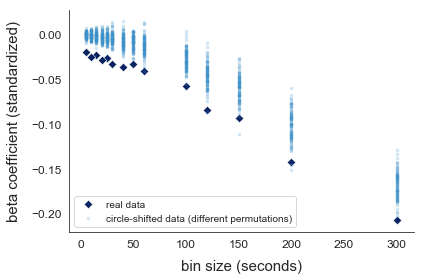

In [10]:
marker_real = 'D'
marker_shuffled = '.'

sns.scatterplot(x="bin_size", y="beta", data=df_real, marker=marker_real, color='#0A2463', label="real data")
sns.scatterplot(x="bin_size", y="betas", data=df_shifted, marker=marker_shuffled, 
                color='#3E92CC', alpha=0.2, edgecolor='#3E92CC',
                label="circle-shifted data (different permutations)")

plt.xlabel('bin size (seconds)', fontsize=15, labelpad=10)
plt.ylabel('beta coefficient (standardized)', fontsize=15, labelpad=10)

plt.tick_params(labelsize=12)

sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(base_dir, 'Figures', 'within_convo_analysis_strangers.png'), dpi=300)


# Quantify performance

How many times (out of 100) does the real beta outperform the circle-shifted data?


In [23]:
performance = pd.DataFrame()
performance = performance.fillna(0)
counter = 0

for i in range(len(df_real)):
    
    bin_size = df_real.at[i, 'bin_size']
    beta_real = df_real.at[i, 'beta']
    data_shifted_bin_subset = df_shifted.loc[df_shifted['bin_size'] == bin_size]
    data_shifted_bin_subset_beat_num = data_shifted_bin_subset.loc[data_shifted_bin_subset['betas'] > beta_real]
    
    performance.at[counter, 'bin_size'] = bin_size
    performance.at[counter, 'beta_beats_null'] = len(data_shifted_bin_subset_beat_num)

    counter += 1

In [24]:
performance

,bin_size,beta_beats_null
0,300.0,100.0
1,200.0,97.0
2,150.0,99.0
3,120.0,99.0
4,100.0,100.0
5,60.0,100.0
6,50.0,100.0
7,40.0,100.0
8,30.0,100.0
9,25.0,100.0
